In [1]:
!nvidia-smi

Mon Apr 22 13:19:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   28C    P0    24W / 150W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#import installed libraries

import sys
from fancy_einsum import einsum

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM, AutoConfig
from transformer_lens import ActivationCache, HookedTransformer

from huggingface_hub import notebook_login
from datasets import Dataset
import pandas as pd
import transformers
import torch
import einops  # Make sure einops is imported
import numpy as np 

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
import circuitsvis as cv
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Import from local libraries

from load_HookedTransformer import load_HookedTransformer
from utils import *
from datasets import load_dataset
from load_Datasets import load_and_concat_openwebtext

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
# Method to calculate ID

def get_ratios(vectors, n_neighbors):
    try:
        N = len(vectors)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto").fit(vectors)
        distances, indices = nbrs.kneighbors(vectors)
        ratios = np.array(
            [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
        )

    except Exception as e:
        print(f"An error occurred: {e}")
        ratios = None
        N = 0

    return ratios, N


def measure_dimension_kNN(
    vectors, n_neighbors=5, fraction=0.9, plot=False, verbose=False
):
    ratios, N = get_ratios(vectors, n_neighbors)
    try:
        mus = [
            np.sort(ratios[i], axis=None, kind="quicksort") for i in range(n_neighbors - 2)
        ]
        Femp = (np.arange(1, N + 1, dtype=np.float64)) / N

        dims = []
        xs = []
        ys = []
        regrs =[]
        for k, mu in enumerate(mus):
            x = np.log(mu[:-2])
            xs += [x]
            y = -np.log(1 - Femp[:-2] ** (1 / (k + 1)))
            ys += [y]

            npoints = int(np.floor(N * fraction))
            regr = linear_model.LinearRegression(fit_intercept=False)
            regr.fit(x[:npoints, np.newaxis], y[:npoints, np.newaxis])
            if verbose:
                print(
                    "From ratio " + str(k + 2) + " NN estimated dim " + str(regr.coef_[0])
                )
            dims += [regr.coef_[0]]
            regrs += [regr]

        if plot:
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.set_title("Log F vs Log mu")
            ax.set_xscale("linear")
            ax.set_yscale("linear")
            for x, y, dim, regr in zip(xs, ys, dims, regrs):
                ax.scatter(x[:npoints], y[:npoints])
                ax.plot(
                    x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
                )
                ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
        else : 
            fig = None
        #print(x[:npoints],regr.predict(x[:npoints].reshape((-1, 1)) ))
        return xs, ys, dims, regrs, npoints, fig
    except:
        return None, None, None, None, None, None


def measure_dimension_MLE(vectors, n_neighbors=10, plot=False, verbose=False):
    ratios, _ = get_ratios(vectors, n_neighbors)
    logs = np.log(ratios)
    estimates = (n_neighbors - 2) / (logs[:, -1] - np.sum(logs[:, :-1], axis=1))
    dim = np.mean(estimates)
    var = np.var(estimates)
    if verbose:
        print("Dimension MLE: ", dim, " Stddev: ", np.sqrt(var))
    if plot:
        fig, axs = plt.subplots(1, 1)
        axs.hist(estimates, bins=50)

    return dim, var, estimates

# GPT2 : Activations -> ID


In [5]:
if False :
    
    final_activations = {
    'last0': {}, 'last1': {}, 'last2': {}, 'last3': {}, 'last10': {}, 'last20': {}, 
    'pos0': {}, 'pos5': {}, 'pos10': {}, 'pos50': {}
    }

    target_keys_substrings = [
        "hook_attn_out",
        "hook_mlp_out",
        "hook_resid_pre",
        "hook_resid_mid",
        "hook_resid_post",
        "ln_final"
    ]

    layer_indices = [0, 1, 2, 3, 5, 7, 9, 10, 11]
    target_layers_substrings = [f"blocks.{index}" for index in layer_indices] + ["ln_final"]

    # Define specific token positions

    names_filter= [key for key in list(model.hook_dict.keys()) if any(substring in key for substring in target_keys_substrings)]
    names_filter= [key for key in names_filter if any(substring in key for substring in target_layers_substrings)]

    last_token_positions=[0,1,2,3,10,20]
    token_positions = [0, 5, 10, 50]

    project_name='final_activation_gpt2_set0_ctx_1024'
    last_idxs= torch.load(Path(project_name)/'last_idxs.pt')

    
    final_activations.keys()

    import itertools
    import pickle

    # Use itertools.product to create combinations
    last_token_ind=1023
    fraction=0.1
    keys=[]
    dims_dict={}
    # Print each combination
    for str_i,str_j in list(itertools.product(names_filter, final_activations.keys()))[:]:
        key=f"{str_i}.{str_j}"
        file=key+".pt"
        activation_tensors0 = torch.load(Path(project_name)/file)
        filtered_data_idx=(np.array(last_idxs)==last_token_ind)
        activation_tensors_filtered=activation_tensors0[filtered_data_idx,:]

        xs, ys, dims, regrs, npoints, fig = measure_dimension_kNN(
            activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=True, verbose=True
        )

        if fig is not None:
            fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))

        dims_dict[key]=dims
        keys+=[key]

    Dimension_analyzed={
        "positions" :list(final_activations.keys()),
        "layer_keys" :target_layers_substrings,
        "layer_ind":layer_indices,
        "names_filter" : names_filter,
        "keys":keys,
        "dims":dims_dict,
        "last_token_ind":last_token_ind,
        "filtered_data_idx":filtered_data_idx,
        "fraction":fraction,
        "sample_num" : len(filtered_data_idx),
        "filtered_sample_num": sum(filtered_data_idx)
    }

    with open(Path(project_name)/'Dimension_analyzed.pkl', 'wb') as f:
        pickle.dump(Dimension_analyzed, f)




# LLAMA : Activations -> ID

In [ ]:
torch.set_grad_enabled(False)
#model,tokenizer = load_HookedTransformer('llama-7b')
model,tokenizer = load_HookedTransformer('llama-7b')


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer


In [ ]:
if False :
    
    final_activations = {
    'last0': {}, 'last1': {}, 'last2': {}, 'last3': {}, 'last10': {}, 'last20': {}, 
    'pos0': {}, 'pos5': {}, 'pos10': {}, 'pos50': {}
    }

    target_keys_substrings = [
        "hook_attn_out",
        "hook_mlp_out",
        "hook_resid_pre",
        "hook_resid_mid",
        "hook_resid_post",
        "ln_final"
    ]

    layer_indices = [0, 1, 2, 8, 15, 23, 29, 30, 31]
    target_layers_substrings = [f"blocks.{index}." for index in layer_indices] + ["ln_final"]

    # Define specific token positions

    names_filter= [key for key in list(model.hook_dict.keys()) if any(substring in key for substring in target_keys_substrings)]
    names_filter= [key for key in names_filter if any(substring in key for substring in target_layers_substrings)]

    last_token_positions=[0,1,2,3,10,20]
    token_positions = [0, 5, 10, 50]

    project_name='final_activation_llama_set0_ctx_1024'
    last_idxs= torch.load(Path(project_name)/'last_idxs.pt')

    
    final_activations.keys()

    import itertools
    import pickle

    # Use itertools.product to create combinations
    last_token_ind=1023
    fraction=0.1
    keys=[]
    dims_dict={}
    # Print each combination
    for str_i,str_j in list(itertools.product(names_filter, final_activations.keys()))[:]:
        key=f"{str_i}.{str_j}"
        file=key+".pt"
        activation_tensors0 = torch.load(Path(project_name)/file)
        filtered_data_idx=(np.array(last_idxs)==last_token_ind)
        activation_tensors_filtered=activation_tensors0[filtered_data_idx,:]

        xs, ys, dims, regrs, npoints, fig = measure_dimension_kNN(
            activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=True, verbose=True
        )

        if fig is not None:
            fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))

        dims_dict[key]=dims
        keys+=[key]

    Dimension_analyzed={
        "positions" :list(final_activations.keys()),
        "layer_keys" :target_layers_substrings,
        "layer_ind":layer_indices,
        "names_filter" : names_filter,
        "keys":keys,
        "dims":dims_dict,
        "last_token_ind":last_token_ind,
        "filtered_data_idx":filtered_data_idx,
        "fraction":fraction,
        "sample_num" : len(filtered_data_idx),
        "filtered_sample_num": sum(filtered_data_idx)
    }

    with open(Path(project_name)/'Dimension_analyzed.pkl', 'wb') as f:
        pickle.dump(Dimension_analyzed, f)




From ratio 2 NN estimated dim [20.5782024]
From ratio 3 NN estimated dim [21.23216729]
From ratio 4 NN estimated dim [20.92616382]
From ratio 2 NN estimated dim [20.7081028]
From ratio 3 NN estimated dim [20.88474648]
From ratio 4 NN estimated dim [20.8670142]
From ratio 2 NN estimated dim [20.57993787]
From ratio 3 NN estimated dim [20.12222498]
From ratio 4 NN estimated dim [20.37880828]
From ratio 2 NN estimated dim [20.45174472]
From ratio 3 NN estimated dim [20.70108081]
From ratio 4 NN estimated dim [20.67639718]
From ratio 2 NN estimated dim [20.69143743]
From ratio 3 NN estimated dim [20.91619206]
From ratio 4 NN estimated dim [20.46959191]
From ratio 2 NN estimated dim [21.02974593]
From ratio 3 NN estimated dim [20.48202477]
From ratio 4 NN estimated dim [20.40241093]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [24.38002591]
From ratio 3 NN estimated dim [20.0202363]
From ratio 4 NN estimated dim [19.61157999]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [19.67441687]
From ratio 3 NN estimated dim [19.98689947]
From ratio 4 NN estimated dim [20.26219581]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [21.47864226]
From ratio 3 NN estimated dim [22.21732866]
From ratio 4 NN estimated dim [22.4263446]
From ratio 2 NN estimated dim [13.51892773]
From ratio 3 NN estimated dim [16.70302447]
From ratio 4 NN estimated dim [18.15543307]
From ratio 2 NN estimated dim [13.43506987]
From ratio 3 NN estimated dim [16.08861125]
From ratio 4 NN estimated dim [18.09147992]
From ratio 2 NN estimated dim [13.4613148]
From ratio 3 NN estimated dim [16.15052134]
From ratio 4 NN estimated dim [17.77885673]
From ratio 2 NN estimated dim [13.27704551]
From ratio 3 NN estimated dim [16.27910412]
From ratio 4 NN estimated dim [17.71929689]
From ratio 2 NN estimated dim [13.30954757]
From ratio 3 NN estimated dim [16.01008335]
From ratio 4 NN estimated dim [17.47806362]
From ratio 2 NN estimated dim [13.26957612]
From ratio 3 NN estimated dim [16.40228329]
From ratio 4 NN estimated dim [18.03722864]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [14.67423337]
From ratio 3 NN estimated dim [15.03448384]
From ratio 4 NN estimated dim [15.89797234]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [12.73415613]
From ratio 3 NN estimated dim [15.07820678]
From ratio 4 NN estimated dim [16.39663565]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [13.12345605]
From ratio 3 NN estimated dim [15.33445917]
From ratio 4 NN estimated dim [16.90555783]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25676952.0.0/ipykernel_3708084/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


In [19]:
names_filter

['blocks.0.hook_attn_out',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_pre',
 'blocks.0.hook_resid_mid',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_attn_out',
 'blocks.1.hook_mlp_out',
 'blocks.1.hook_resid_pre',
 'blocks.1.hook_resid_mid',
 'blocks.1.hook_resid_post',
 'blocks.2.hook_attn_out',
 'blocks.2.hook_mlp_out',
 'blocks.2.hook_resid_pre',
 'blocks.2.hook_resid_mid',
 'blocks.2.hook_resid_post',
 'blocks.8.hook_attn_out',
 'blocks.8.hook_mlp_out',
 'blocks.8.hook_resid_pre',
 'blocks.8.hook_resid_mid',
 'blocks.8.hook_resid_post',
 'blocks.15.hook_attn_out',
 'blocks.15.hook_mlp_out',
 'blocks.15.hook_resid_pre',
 'blocks.15.hook_resid_mid',
 'blocks.15.hook_resid_post',
 'blocks.23.hook_attn_out',
 'blocks.23.hook_mlp_out',
 'blocks.23.hook_resid_pre',
 'blocks.23.hook_resid_mid',
 'blocks.23.hook_resid_post',
 'blocks.29.hook_attn_out',
 'blocks.29.hook_mlp_out',
 'blocks.29.hook_resid_pre',
 'blocks.29.hook_resid_mid',
 'blocks.29.hook_resid_post',
 'blocks.30.hook_at

In [ ]:
5=5
print("Done")

# MISTRAL : Activations -> ID

In [7]:
if False :
    
    torch.set_grad_enabled(False)
    #model,tokenizer = load_HookedTransformer('llama-7b')
    model,tokenizer = load_HookedTransformer('mistral-7b')
    
    
    final_activations = {
    'last0': {}, 'last1': {}, 'last2': {}, 'last3': {}, 'last10': {}, 'last20': {}, 
    'pos0': {}, 'pos5': {}, 'pos10': {}, 'pos50': {}
    }

    target_keys_substrings = [
        "hook_attn_out",
        "hook_mlp_out",
        "hook_resid_pre",
        "hook_resid_mid",
        "hook_resid_post",
        "ln_final"
    ]

    layer_indices = [0, 1, 2, 8, 15, 23, 29, 30, 31]
    target_layers_substrings = [f"blocks.{index}" for index in layer_indices] + ["ln_final"]

    # Define specific token positions

    names_filter= [key for key in list(model.hook_dict.keys()) if any(substring in key for substring in target_keys_substrings)]
    names_filter= [key for key in names_filter if any(substring in key for substring in target_layers_substrings)]

    last_token_positions=[0,1,2,3,10,20]
    token_positions = [0, 5, 10, 50]

    project_name='final_activation_llama_set0_ctx_1024'
    last_idxs= torch.load(Path(project_name)/'last_idxs.pt')

    
    final_activations.keys()

    import itertools
    import pickle

    # Use itertools.product to create combinations
    last_token_ind=1023
    fraction=0.1
    keys=[]
    dims_dict={}
    # Print each combination
    for str_i,str_j in list(itertools.product(names_filter, final_activations.keys()))[:2]:
        key=f"{str_i}.{str_j}"
        file=key+".pt"
        activation_tensors0 = torch.load(Path(project_name)/file)
        filtered_data_idx=(np.array(last_idxs)==last_token_ind)
        activation_tensors_filtered=activation_tensors0[filtered_data_idx,:]

        xs, ys, dims, regrs, npoints, fig = measure_dimension_kNN(
            activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=True, verbose=True
        )

        if fig is not None:
            fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))

        dims_dict[key]=dims
        keys+=[key]

    Dimension_analyzed={
        "positions" :list(final_activations.keys()),
        "layer_keys" :target_layers_substrings,
        "layer_ind":layer_indices,
        "names_filter" : names_filter,
        "keys":keys,
        "dims":dims_dict,
        "last_token_ind":last_token_ind,
        "filtered_data_idx":filtered_data_idx,
        "fraction":fraction,
        "sample_num" : len(filtered_data_idx),
        "filtered_sample_num": sum(filtered_data_idx)
    }

    with open(Path(project_name)/'Dimension_analyzed.pkl', 'wb') as f:
        pickle.dump(Dimension_analyzed, f)




# Plot ID sets

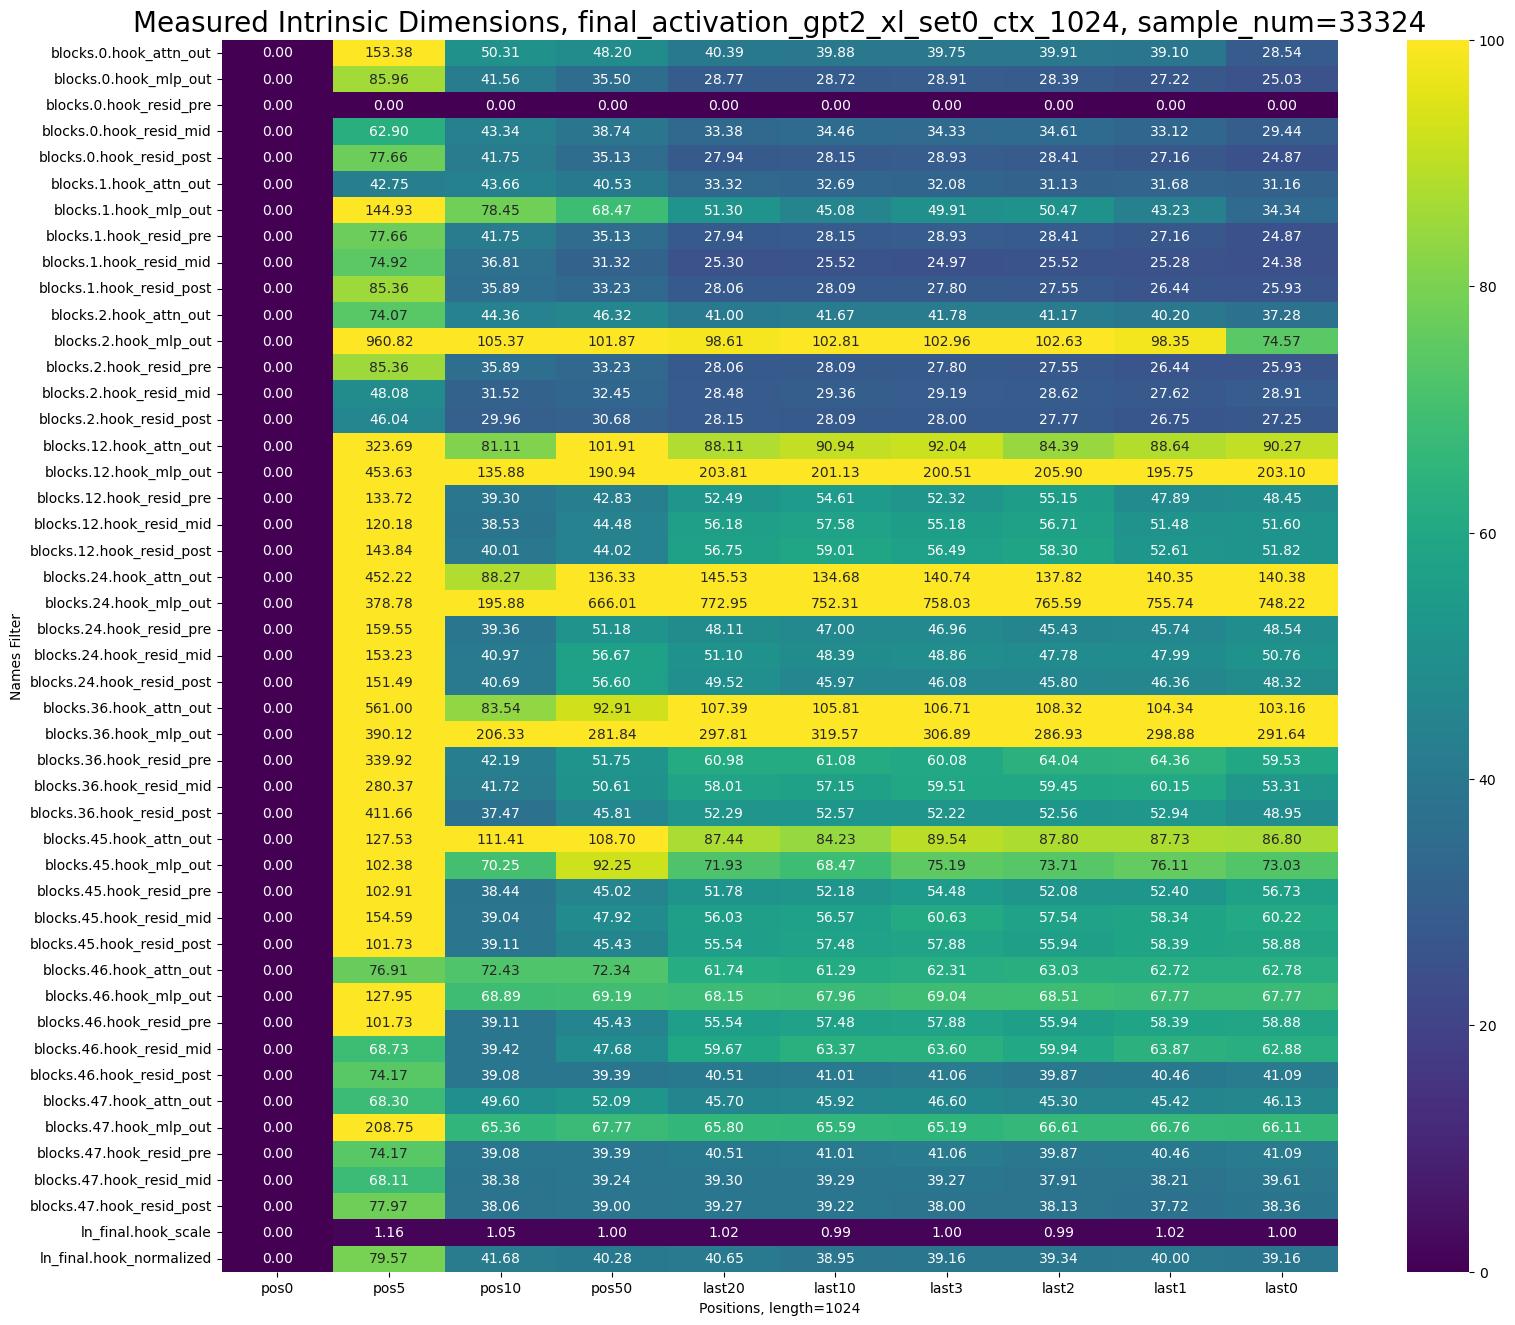

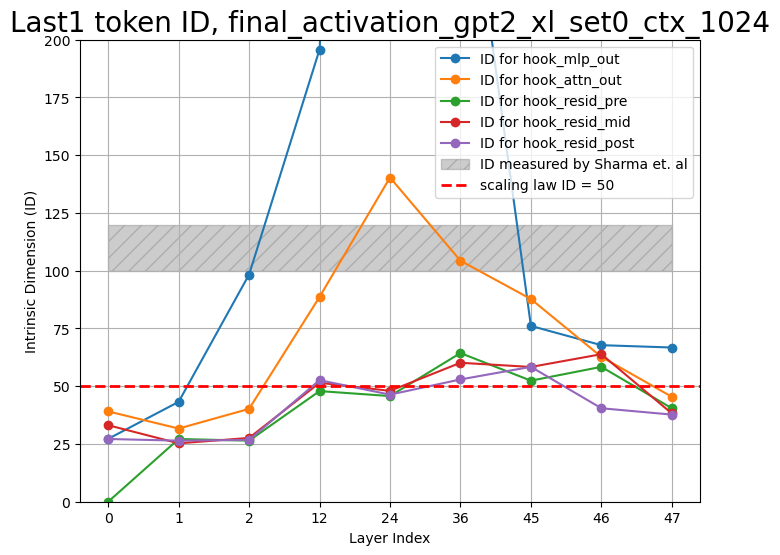

Plot saved to: final_activation_gpt2_xl_set0_ctx_1024/AnalysisPlot_lasttoken_layerwise_ID.png


In [4]:
import pickle 

project_name = 'final_activation_gpt2_xl_set0_ctx_1024'
# Load the data from the .pkl file
with open(Path(project_name)/'Dimension_analyzed.pkl', 'rb') as file:
    Dimension_analyzed= pickle.load(file)

def position_sort_key(s):
    # Determine if the string starts with 'pos' or 'last'
    if s.startswith('pos'):
        group = 0  # 'pos' items come first
        # Extract the numeric part and sort normally
        order = int(''.join(filter(str.isdigit, s)))
    elif s.startswith('last'):
        group = 1  # 'last' items come second
        # Extract the numeric part and sort in reverse
        order = -int(''.join(filter(str.isdigit, s)))
    else:
        group = 2  # Handle unexpected cases
        order = 0

    return (group, order)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

########################################################################################################################################################
############## First plot 
########################################################################################################################################################

# Setup your data structure for the heatmap
names_filter = Dimension_analyzed['names_filter']
positions = Dimension_analyzed['positions']
positions = sorted(positions, key=position_sort_key)
layer_ind=Dimension_analyzed['layer_ind']
heat_values = []
filtered_sample_num = Dimension_analyzed['filtered_sample_num']
last_token_ind= Dimension_analyzed['last_token_ind']
# Populate the 2D array for the heatmap
for name in names_filter:
    row = []
    for position in positions:
        key = f"{name}.{position}"
        dims = Dimension_analyzed['dims'].get(key, None)
        value = 0 if dims is None else np.mean(dims)  # Use 0 if key might not exist or dims is None
        row.append(value)
    heat_values.append(row)

# Convert to numpy array for better handling in heatmap
heat_values = np.array(heat_values)

# Creating the heatmap
fig = plt.figure(figsize=(18, 16))
sns.heatmap(heat_values, yticklabels=names_filter, xticklabels=positions, cmap='viridis',
            annot=True, fmt=".2f", vmin=0, vmax=100)
plt.title(f'Measured Intrinsic Dimensions, {project_name}, sample_num={filtered_sample_num}',size=20)
plt.xlabel(f'Positions, length={last_token_ind+1}')
plt.ylabel('Names Filter')
fig.savefig(Path(project_name) / "AnalysisPlot_Heatmap_ID.png")
plt.show()

########################################################################################################################################################
############## Second plot 
########################################################################################################################################################

layer_names=['hook_mlp_out', 'hook_attn_out', 'hook_resid_pre', 'hook_resid_mid', 'hook_resid_post']
uniform_positions = list(range(len(layer_ind)))

# Create a line plot for each layer name
plt.figure(figsize=(8, 6))
for layer_name in layer_names:
    dims_values = []
    for layer_i in layer_ind:
        key = f"blocks.{layer_i}.{layer_name}.last1"
        dims = Dimension_analyzed['dims'].get(key, None)
        value = 0 if dims is None else np.mean(dims)  # Use 0 if key might not exist or dims is None
        dims_values.append(value)

    # Plotting with uniform x-axis positions
    plt.plot(uniform_positions, dims_values, marker='o', linestyle='-', label=f'ID for {layer_name}')
plt.fill_between(uniform_positions, 100, 120, color='gray', alpha=0.4, label=f'ID measured by Sharma et. al', hatch='//')
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label=f'scaling law ID = 50')

# Set custom tick labels
plt.xticks(uniform_positions, layer_ind)
plt.title(f'Last1 token ID, {project_name}', size=20)
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension (ID)')
plt.grid(True)
plt.legend()

ax = plt.gca()
ax.set_ylim([0,200])
# Save the figure
plt_path = Path(project_name) / "AnalysisPlot_lasttoken_layerwise_ID.png"
plt.savefig(plt_path)
plt.show()

# Informing user about the saved plot
print(f"Plot saved to: {plt_path}")

########################################################################################################################################################
############## Third plot 
########################################################################################################################################################



In [61]:
name='blocks.5.hook_mlp_out'
position='last3'
key = f"{name}.{position}"
Dimension_analyzed['dims'].get(key, 0)

[array([68.39121874]), array([82.41163198]), array([89.3052035])]

In [18]:
Dimension_analyzed['dims'].keys()

# LLAMA & MISTRAL

In [28]:
Dimension_analyzed['keys'][0]

'blocks.0.hook_attn_out.last0'

In [36]:
layer_ind

[0, 1, 2, 8, 15, 23, 29, 30, 31]

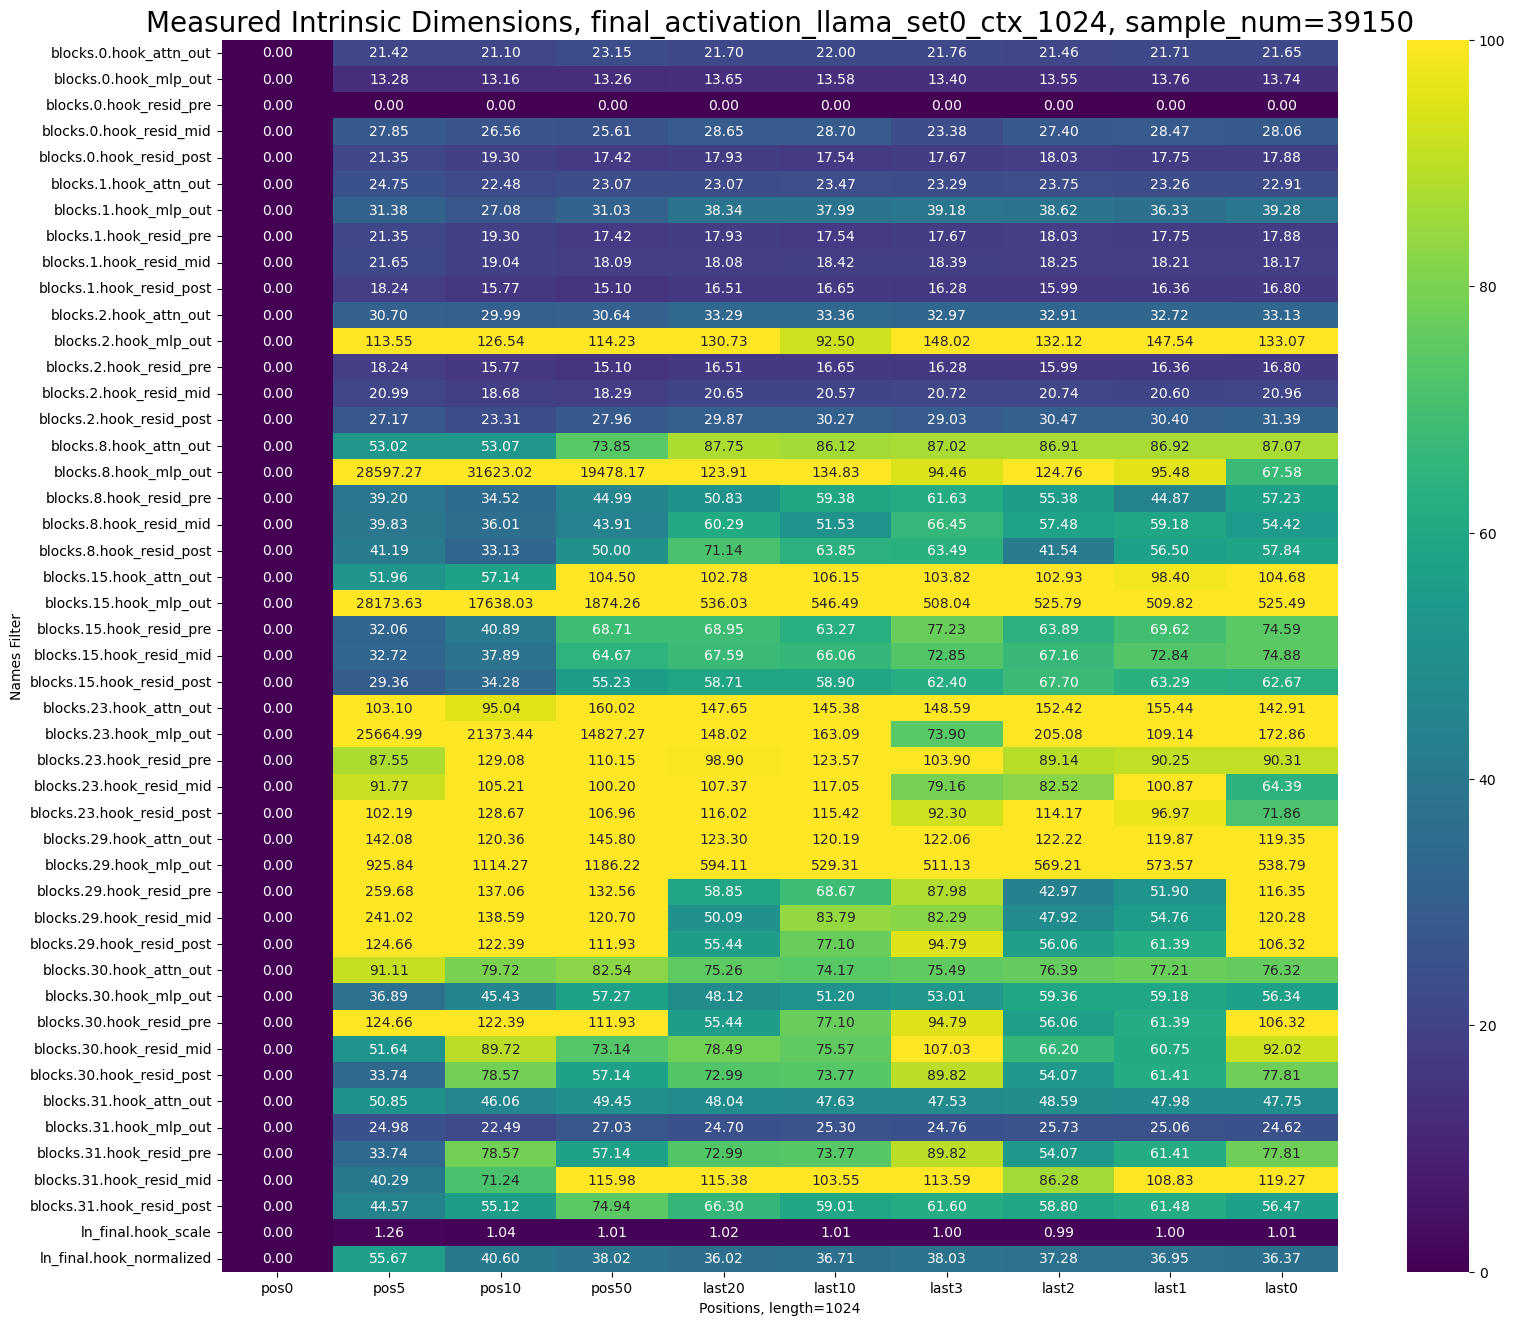

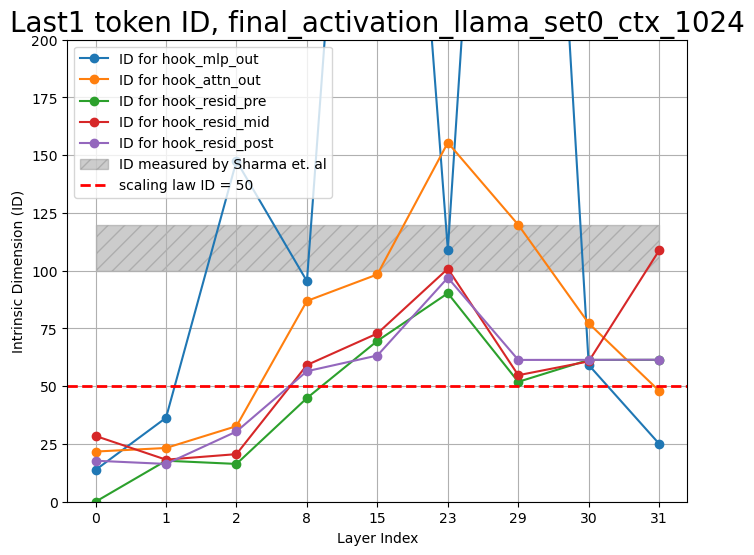

Plot saved to: final_activation_llama_set0_ctx_1024/AnalysisPlot_lasttoken_layerwise_ID.png


In [5]:
import pickle 

project_name = 'final_activation_llama_set0_ctx_1024'
# Load the data from the .pkl file
with open(Path(project_name)/'Dimension_analyzed.pkl', 'rb') as file:
    Dimension_analyzed= pickle.load(file)

def position_sort_key(s):
    # Determine if the string starts with 'pos' or 'last'
    if s.startswith('pos'):
        group = 0  # 'pos' items come first
        # Extract the numeric part and sort normally
        order = int(''.join(filter(str.isdigit, s)))
    elif s.startswith('last'):
        group = 1  # 'last' items come second
        # Extract the numeric part and sort in reverse
        order = -int(''.join(filter(str.isdigit, s)))
    else:
        group = 2  # Handle unexpected cases
        order = 0

    return (group, order)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

########################################################################################################################################################
############## First plot 
########################################################################################################################################################

# Setup your data structure for the heatmap
names_filter = Dimension_analyzed['names_filter']
positions = Dimension_analyzed['positions']
positions = sorted(positions, key=position_sort_key)
layer_ind=Dimension_analyzed['layer_ind']
heat_values = []
filtered_sample_num = Dimension_analyzed['filtered_sample_num']
last_token_ind= Dimension_analyzed['last_token_ind']
# Populate the 2D array for the heatmap
for name in names_filter:
    row = []
    for position in positions:
        key = f"{name}.{position}"
        dims = Dimension_analyzed['dims'].get(key, None)
        value = 0 if dims is None else np.mean(dims)  # Use 0 if key might not exist or dims is None
        row.append(value)
    heat_values.append(row)

# Convert to numpy array for better handling in heatmap
heat_values = np.array(heat_values)

# Creating the heatmap
fig = plt.figure(figsize=(18, 16))
sns.heatmap(heat_values, yticklabels=names_filter, xticklabels=positions, cmap='viridis',
            annot=True, fmt=".2f", vmin=0, vmax=100)
plt.title(f'Measured Intrinsic Dimensions, {project_name}, sample_num={filtered_sample_num}',size=20)
plt.xlabel(f'Positions, length={last_token_ind+1}')
plt.ylabel('Names Filter')
fig.savefig(Path(project_name) / "AnalysisPlot_Heatmap_ID.png")
plt.show()

########################################################################################################################################################
############## Second plot 
########################################################################################################################################################

layer_names=['hook_mlp_out', 'hook_attn_out', 'hook_resid_pre', 'hook_resid_mid', 'hook_resid_post']
uniform_positions = list(range(len(layer_ind)))

# Create a line plot for each layer name
plt.figure(figsize=(8, 6))
for layer_name in layer_names:
    dims_values = []
    for layer_i in layer_ind:
        key = f"blocks.{layer_i}.{layer_name}.last1"
        dims = Dimension_analyzed['dims'].get(key, None)
        value = 0 if dims is None else np.mean(dims)  # Use 0 if key might not exist or dims is None
        dims_values.append(value)

    # Plotting with uniform x-axis positions
    plt.plot(uniform_positions, dims_values, marker='o', linestyle='-', label=f'ID for {layer_name}')
plt.fill_between(uniform_positions, 100, 120, color='gray', alpha=0.4, label=f'ID measured by Sharma et. al', hatch='//')
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label=f'scaling law ID = 50')

# Set custom tick labels
plt.xticks(uniform_positions, layer_ind)
plt.title(f'Last1 token ID, {project_name}', size=20)
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension (ID)')
plt.grid(True)
plt.legend()

ax = plt.gca()
ax.set_ylim([0,200])
# Save the figure
plt_path = Path(project_name) / "AnalysisPlot_lasttoken_layerwise_ID.png"
plt.savefig(plt_path)
plt.show()

# Informing user about the saved plot
print(f"Plot saved to: {plt_path}")

########################################################################################################################################################
############## Third plot 
########################################################################################################################################################



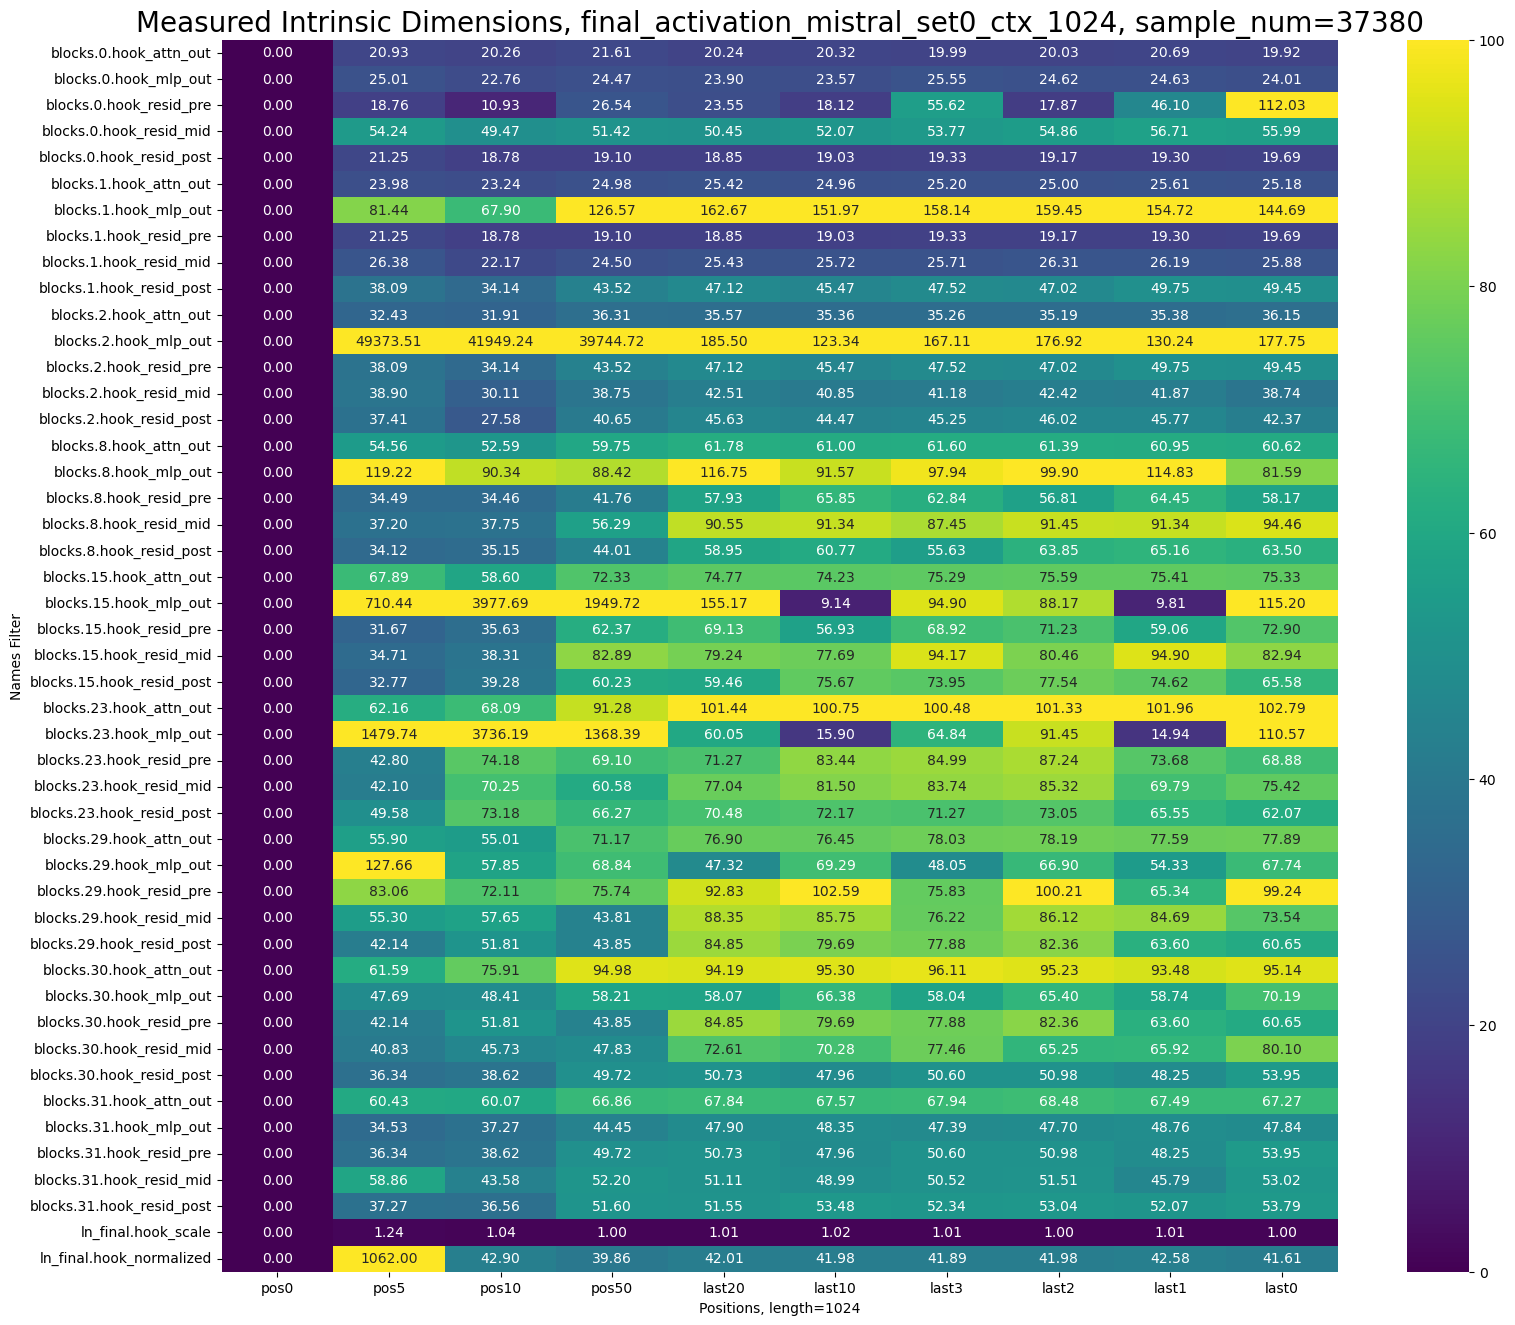

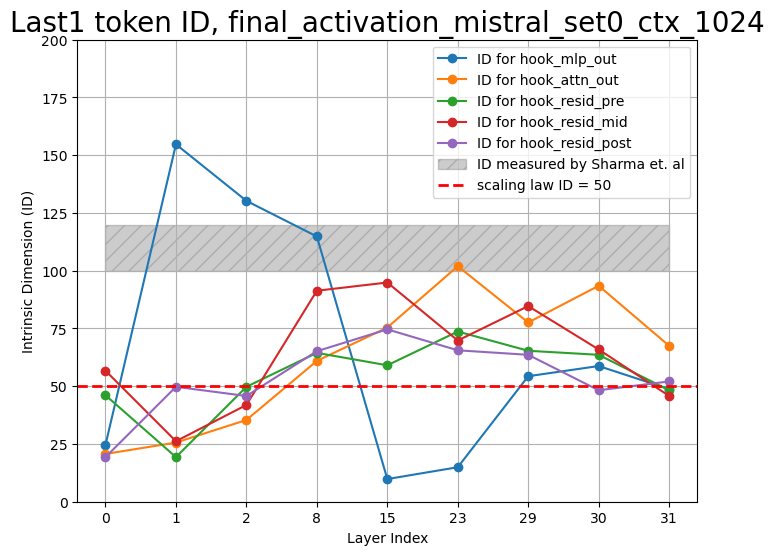

Plot saved to: final_activation_mistral_set0_ctx_1024/AnalysisPlot_lasttoken_layerwise_ID.png


In [6]:
import pickle 

project_name = 'final_activation_mistral_set0_ctx_1024'
# Load the data from the .pkl file
with open(Path(project_name)/'Dimension_analyzed.pkl', 'rb') as file:
    Dimension_analyzed= pickle.load(file)

def position_sort_key(s):
    # Determine if the string starts with 'pos' or 'last'
    if s.startswith('pos'):
        group = 0  # 'pos' items come first
        # Extract the numeric part and sort normally
        order = int(''.join(filter(str.isdigit, s)))
    elif s.startswith('last'):
        group = 1  # 'last' items come second
        # Extract the numeric part and sort in reverse
        order = -int(''.join(filter(str.isdigit, s)))
    else:
        group = 2  # Handle unexpected cases
        order = 0

    return (group, order)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

########################################################################################################################################################
############## First plot 
########################################################################################################################################################

# Setup your data structure for the heatmap
names_filter = Dimension_analyzed['names_filter']
positions = Dimension_analyzed['positions']
positions = sorted(positions, key=position_sort_key)
layer_ind=Dimension_analyzed['layer_ind']
heat_values = []
filtered_sample_num = Dimension_analyzed['filtered_sample_num']
last_token_ind= Dimension_analyzed['last_token_ind']
# Populate the 2D array for the heatmap
for name in names_filter:
    row = []
    for position in positions:
        key = f"{name}.{position}"
        dims = Dimension_analyzed['dims'].get(key, None)
        value = 0 if dims is None else np.mean(dims)  # Use 0 if key might not exist or dims is None
        row.append(value)
    heat_values.append(row)

# Convert to numpy array for better handling in heatmap
heat_values = np.array(heat_values)

# Creating the heatmap
fig = plt.figure(figsize=(18, 16))
sns.heatmap(heat_values, yticklabels=names_filter, xticklabels=positions, cmap='viridis',
            annot=True, fmt=".2f", vmin=0, vmax=100)
plt.title(f'Measured Intrinsic Dimensions, {project_name}, sample_num={filtered_sample_num}',size=20)
plt.xlabel(f'Positions, length={last_token_ind+1}')
plt.ylabel('Names Filter')
fig.savefig(Path(project_name) / "AnalysisPlot_Heatmap_ID.png")
plt.show()

########################################################################################################################################################
############## Second plot 
########################################################################################################################################################

layer_names=['hook_mlp_out', 'hook_attn_out', 'hook_resid_pre', 'hook_resid_mid', 'hook_resid_post']
uniform_positions = list(range(len(layer_ind)))

# Create a line plot for each layer name
plt.figure(figsize=(8, 6))
for layer_name in layer_names:
    dims_values = []
    for layer_i in layer_ind:
        key = f"blocks.{layer_i}.{layer_name}.last1"
        dims = Dimension_analyzed['dims'].get(key, None)
        value = 0 if dims is None else np.mean(dims)  # Use 0 if key might not exist or dims is None
        dims_values.append(value)

    # Plotting with uniform x-axis positions
    plt.plot(uniform_positions, dims_values, marker='o', linestyle='-', label=f'ID for {layer_name}')
plt.fill_between(uniform_positions, 100, 120, color='gray', alpha=0.4, label=f'ID measured by Sharma et. al', hatch='//')
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label=f'scaling law ID = 50')

# Set custom tick labels
plt.xticks(uniform_positions, layer_ind)
plt.title(f'Last1 token ID, {project_name}', size=20)
plt.xlabel('Layer Index')
plt.ylabel('Intrinsic Dimension (ID)')
plt.grid(True)
plt.legend()

ax = plt.gca()
ax.set_ylim([0,200])
# Save the figure
plt_path = Path(project_name) / "AnalysisPlot_lasttoken_layerwise_ID.png"
plt.savefig(plt_path)
plt.show()

# Informing user about the saved plot
print(f"Plot saved to: {plt_path}")

########################################################################################################################################################
############## Third plot 
########################################################################################################################################################



# All samples with out length filtering

In [84]:
project_name='final_activation_gpt2_set0_ctx_1024'
last_idxs= torch.load(Path(project_name)/'last_idxs.pt')
os.listdir(project_name)
file='blocks.11.hook_resid_post.last1.pt'
activation_tensors0 = torch.load(Path(project_name)/file)

From ratio 2 NN estimated dim [24.97897472]
From ratio 3 NN estimated dim [26.78086483]
From ratio 4 NN estimated dim [28.31956521]
From ratio 2 NN estimated dim [24.43941033]
From ratio 3 NN estimated dim [26.0424927]
From ratio 4 NN estimated dim [27.22314415]
From ratio 2 NN estimated dim [23.95130249]
From ratio 3 NN estimated dim [25.36546336]
From ratio 4 NN estimated dim [26.30862428]
From ratio 2 NN estimated dim [23.51133269]
From ratio 3 NN estimated dim [24.71581112]
From ratio 4 NN estimated dim [25.4419766]
From ratio 2 NN estimated dim [23.07682523]
From ratio 3 NN estimated dim [23.98502273]
From ratio 4 NN estimated dim [24.52403946]
From ratio 2 NN estimated dim [22.56305568]
From ratio 3 NN estimated dim [23.15028355]
From ratio 4 NN estimated dim [23.51129284]
From ratio 2 NN estimated dim [21.80371069]
From ratio 3 NN estimated dim [22.07120654]
From ratio 4 NN estimated dim [22.30000346]
From ratio 2 NN estimated dim [20.68975516]
From ratio 3 NN estimated dim [20.

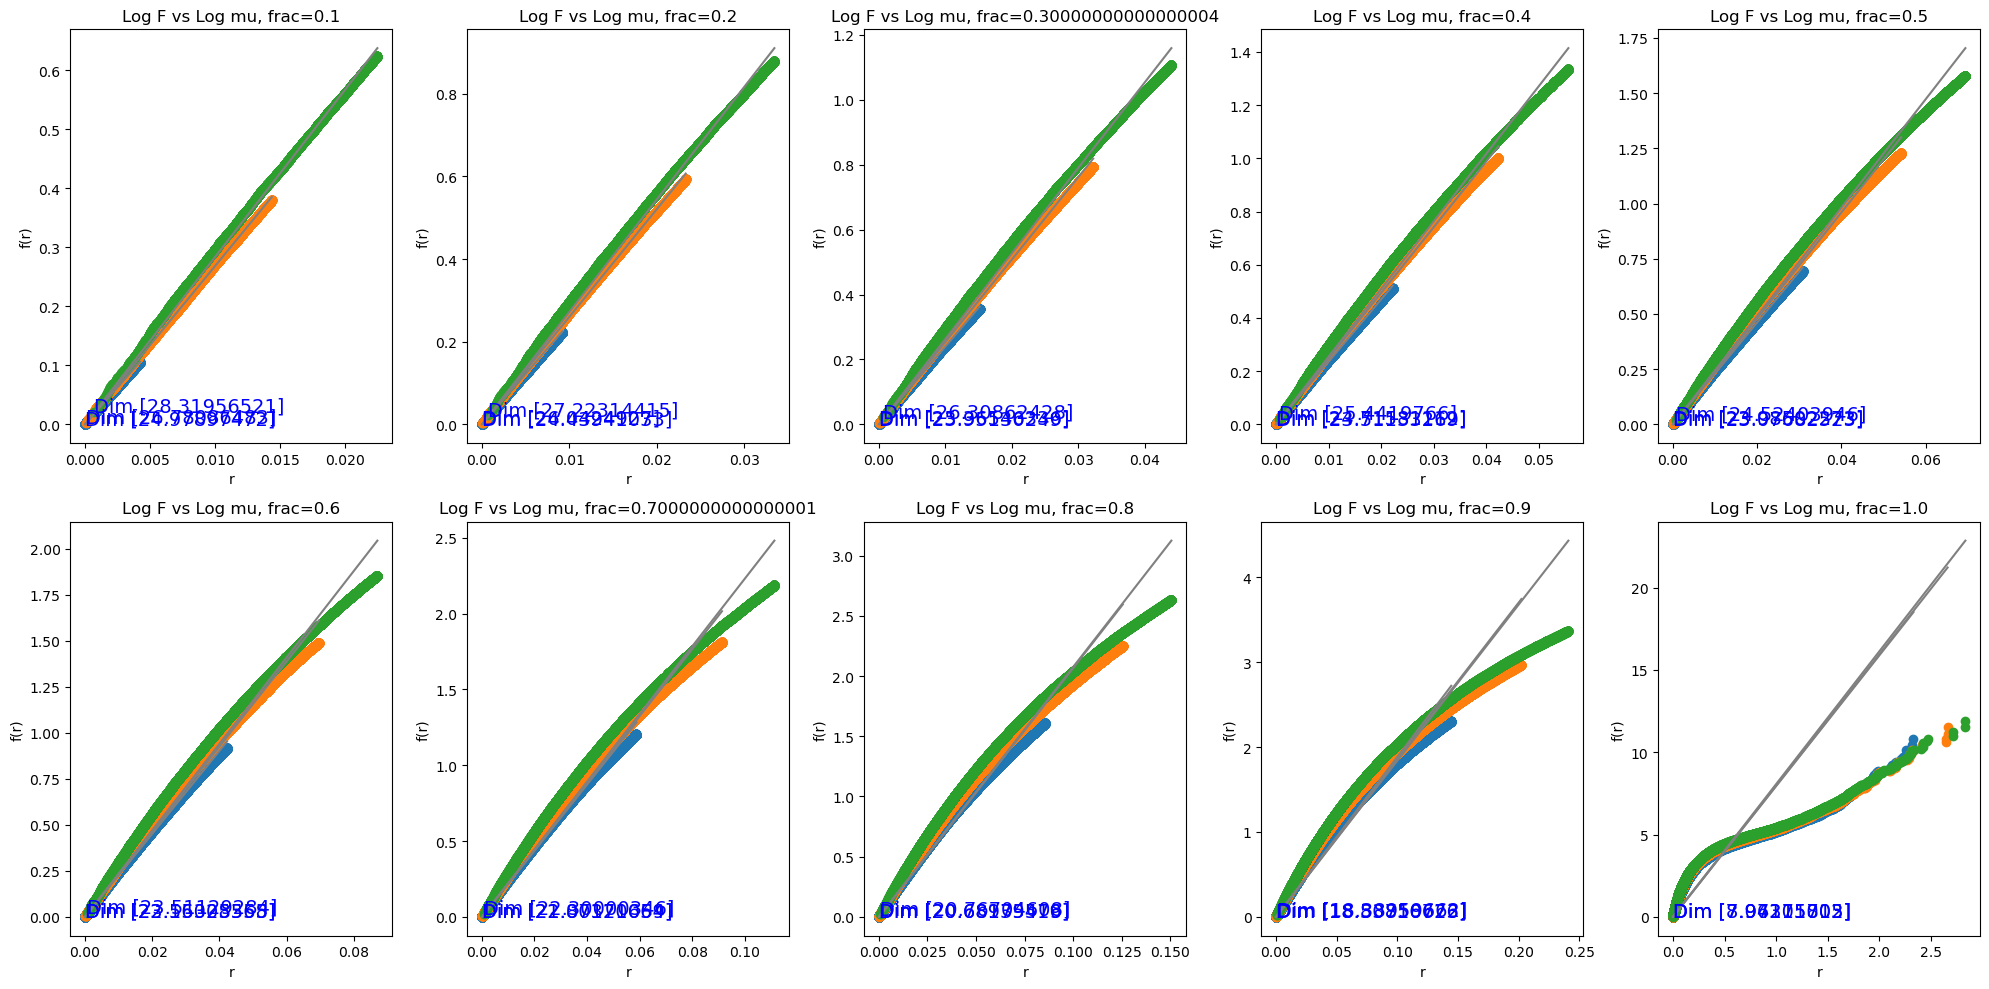

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Import your methods here
# from your_module import measure_dimension_kNN  # Adjust accordingly if needed

# Define the subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Creates a 2x5 grid of plots
axes = axes.ravel()  # Flatten the axes array for easy access

# Iterate over the fractions and generate plots
fractions = np.linspace(0.1, 1.0, 10)  # Creates 10 fractions from 0.1 to 1.0
for i, fraction in enumerate(fractions[:]):
    xs, ys, dims, regrs, npoints, _ = measure_dimension_kNN(
        activation_tensors0, n_neighbors=5, fraction=fraction, plot=False, verbose=True
    )
    
                
    ax = axes[i]  # Select the appropriate subplot axis
    ax.set_title(f"Log F vs Log mu, frac={fraction}")
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        ax.scatter(x[:npoints], y[:npoints])
        ax.plot(
            x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
        )
        ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
                
    ax.set_xlabel("r")  # Set x-label
    ax.set_ylabel("f(r)")  # Set y-label
    ax.axis('on')  # Show axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the complete figure with subplots

# Save the figure
fig.savefig(Path(project_name)/'AnalysisPlot_fraction_dependency_blocks.11.hook_resid_post.last1_noLengthFiltering.png')  # Adjust the path as needed


# All samples with length filtering

In [71]:
project_name='final_activation_gpt2_set0_ctx_1024'
last_idxs= torch.load(Path(project_name)/'last_idxs.pt')
file='blocks.11.hook_resid_post.last1.pt'
activation_tensors0 = torch.load(Path(project_name)/file)

In [75]:
filtered_idx=(np.array(last_idxs)==1023)
activation_tensors_filtered=activation_tensors0[filtered_idx,:]

From ratio 2 NN estimated dim [28.00272898]
From ratio 3 NN estimated dim [28.97765908]
From ratio 4 NN estimated dim [30.05890627]
From ratio 2 NN estimated dim [27.5024968]
From ratio 3 NN estimated dim [28.35716805]
From ratio 4 NN estimated dim [29.24945803]
From ratio 2 NN estimated dim [27.19088042]
From ratio 3 NN estimated dim [27.93475361]
From ratio 4 NN estimated dim [28.60991067]
From ratio 2 NN estimated dim [26.72986363]
From ratio 3 NN estimated dim [27.43826843]
From ratio 4 NN estimated dim [28.00328041]
From ratio 2 NN estimated dim [26.31462571]
From ratio 3 NN estimated dim [26.9110824]
From ratio 4 NN estimated dim [27.36688102]
From ratio 2 NN estimated dim [25.87869622]
From ratio 3 NN estimated dim [26.31598007]
From ratio 4 NN estimated dim [26.65286405]
From ratio 2 NN estimated dim [25.30618631]
From ratio 3 NN estimated dim [25.55173592]
From ratio 4 NN estimated dim [25.76909808]
From ratio 2 NN estimated dim [24.54699777]
From ratio 3 NN estimated dim [24.

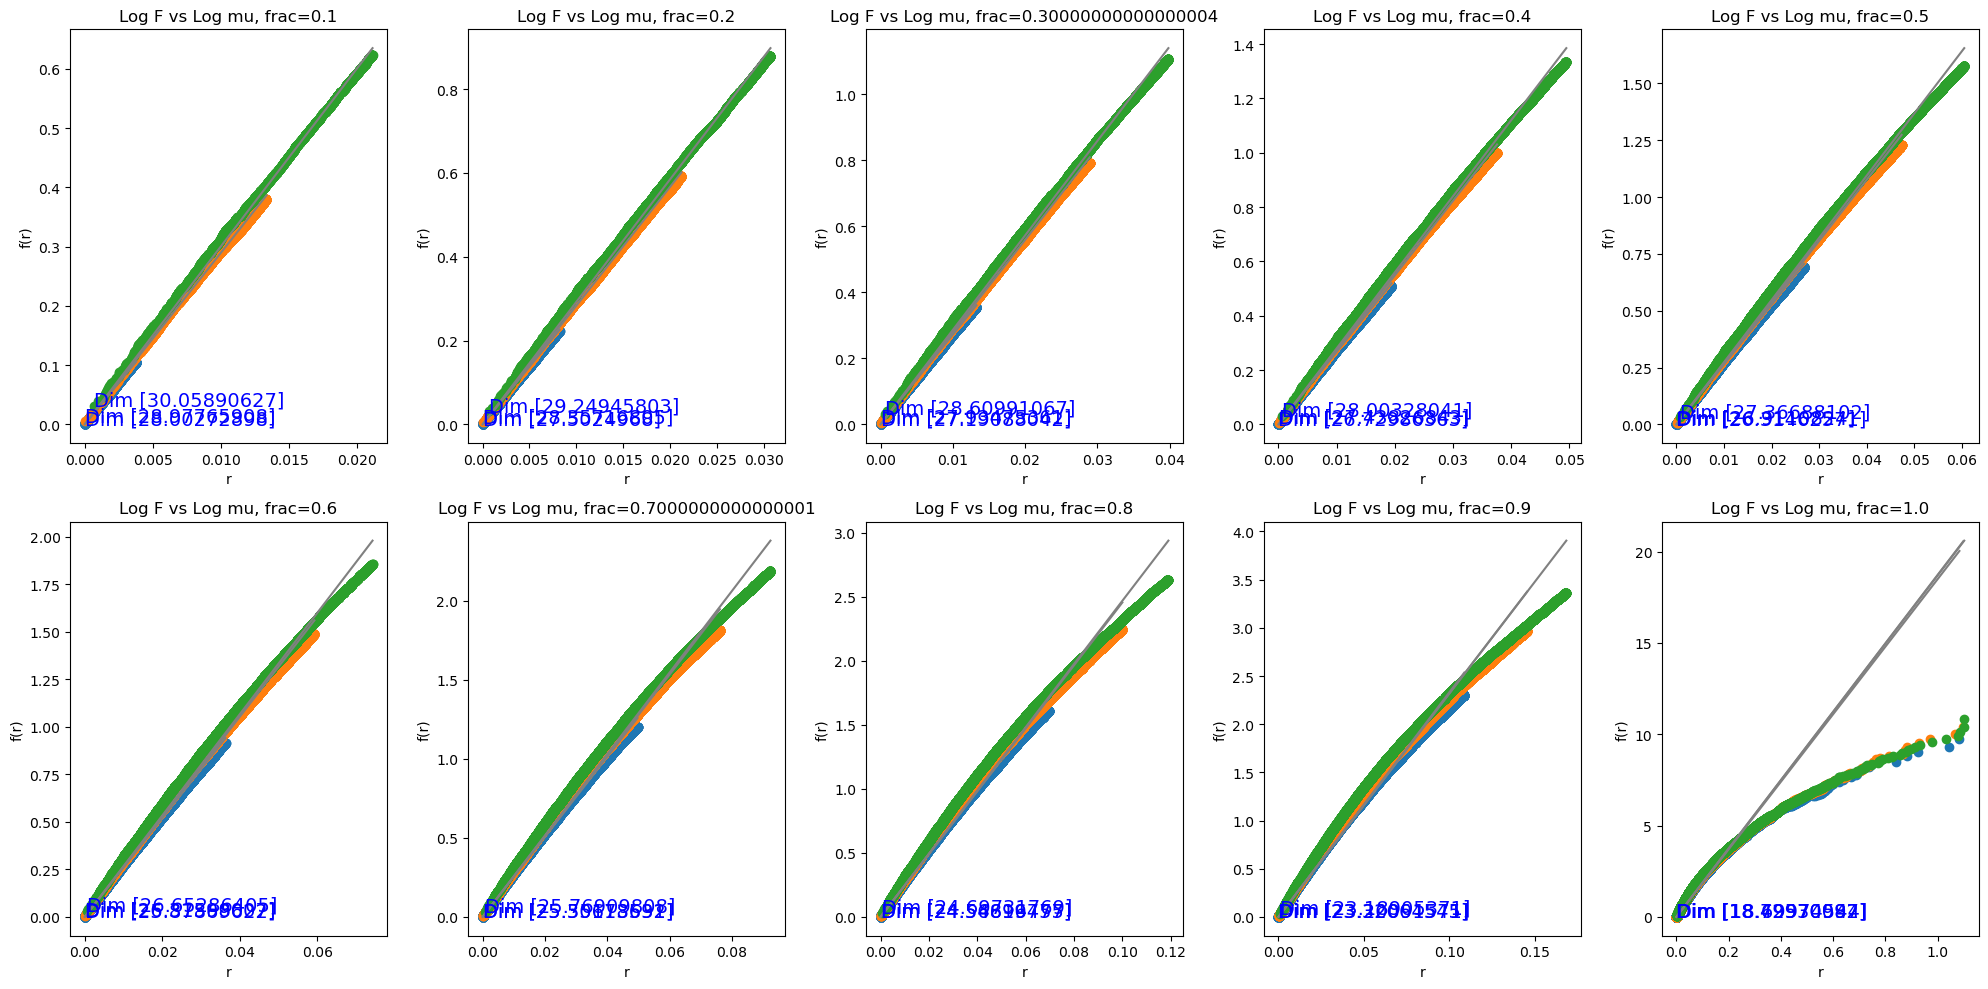

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Import your methods here
# from your_module import measure_dimension_kNN  # Adjust accordingly if needed

# Define the subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Creates a 2x5 grid of plots
axes = axes.ravel()  # Flatten the axes array for easy access

# Iterate over the fractions and generate plots
fractions = np.linspace(0.1, 1.0, 10)  # Creates 10 fractions from 0.1 to 1.0
for i, fraction in enumerate(fractions[:]):
    xs, ys, dims, regrs, npoints, _ = measure_dimension_kNN(
        activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=False, verbose=True
    )
    
                
    ax = axes[i]  # Select the appropriate subplot axis
    ax.set_title(f"Log F vs Log mu, frac={fraction}")
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        ax.scatter(x[:npoints], y[:npoints])
        ax.plot(
            x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
        )
        ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
                
    ax.set_xlabel("r")  # Set x-label
    ax.set_ylabel("f(r)")  # Set y-label
    ax.axis('on')  # Show axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the complete figure with subplots

# Save the figure
fig.savefig(Path(project_name)/'AnalysisPlot_fraction_dependency_blocks.11.hook_resid_post.last1_withLengthFiltering.png')  # Adjust the path as needed


In [85]:
project_name='final_activation_gpt2_set0_ctx_1024'
last_idxs= torch.load(Path(project_name)/'last_idxs.pt')
file='blocks.11.hook_resid_post.last0.pt'
activation_tensors0 = torch.load(Path(project_name)/file)
filtered_idx=(np.array(last_idxs)==1023)
activation_tensors_filtered=activation_tensors0[filtered_idx,:]

From ratio 2 NN estimated dim [27.3308676]
From ratio 3 NN estimated dim [28.99674646]
From ratio 4 NN estimated dim [30.21558216]
From ratio 2 NN estimated dim [27.16252347]
From ratio 3 NN estimated dim [28.46020693]
From ratio 4 NN estimated dim [29.35310765]
From ratio 2 NN estimated dim [26.9941994]
From ratio 3 NN estimated dim [28.05026845]
From ratio 4 NN estimated dim [28.76281629]
From ratio 2 NN estimated dim [26.8035089]
From ratio 3 NN estimated dim [27.60704112]
From ratio 4 NN estimated dim [28.13272729]
From ratio 2 NN estimated dim [26.54865153]
From ratio 3 NN estimated dim [27.08672141]
From ratio 4 NN estimated dim [27.50204279]
From ratio 2 NN estimated dim [26.08430533]
From ratio 3 NN estimated dim [26.49230777]
From ratio 4 NN estimated dim [26.8116351]
From ratio 2 NN estimated dim [25.49891849]
From ratio 3 NN estimated dim [25.81465391]
From ratio 4 NN estimated dim [26.01483589]
From ratio 2 NN estimated dim [24.85585852]
From ratio 3 NN estimated dim [24.92

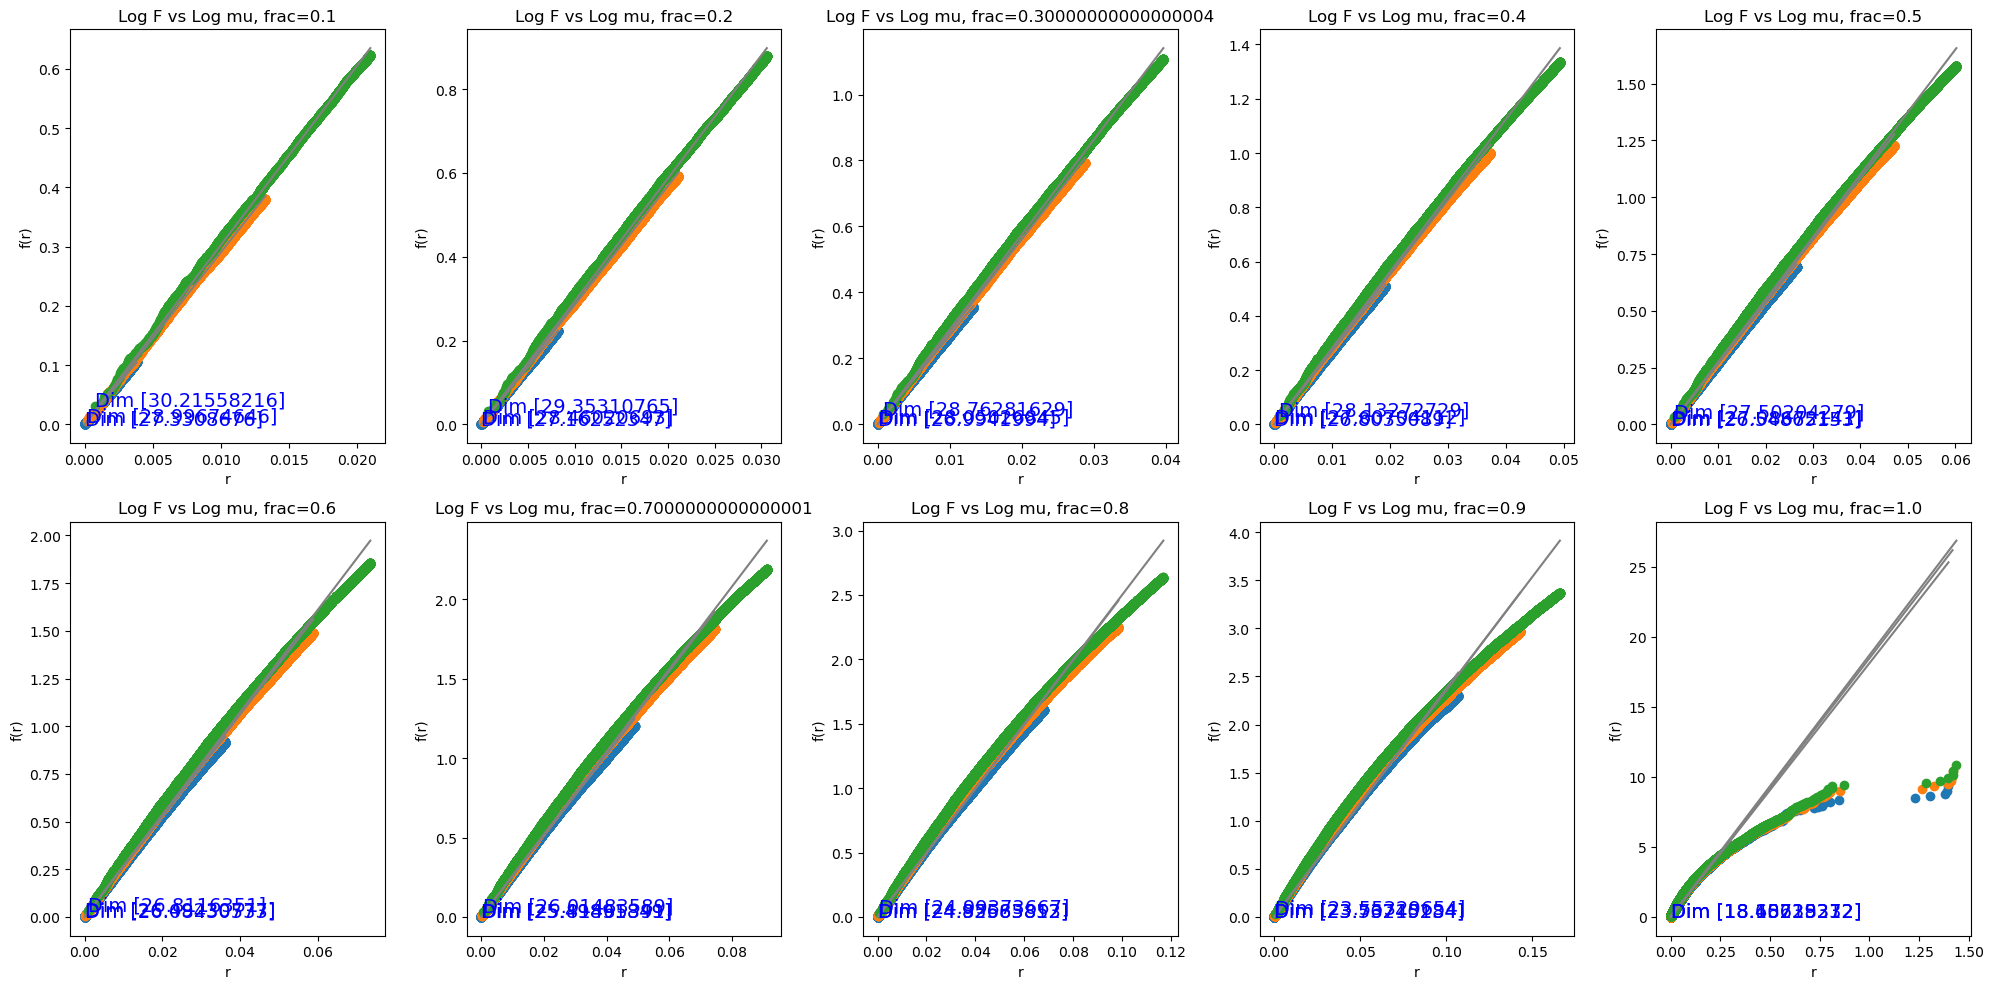

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Import your methods here
# from your_module import measure_dimension_kNN  # Adjust accordingly if needed

# Define the subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Creates a 2x5 grid of plots
axes = axes.ravel()  # Flatten the axes array for easy access

# Iterate over the fractions and generate plots
fractions = np.linspace(0.1, 1.0, 10)  # Creates 10 fractions from 0.1 to 1.0
for i, fraction in enumerate(fractions[:]):
    xs, ys, dims, regrs, npoints, _ = measure_dimension_kNN(
        activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=False, verbose=True
    )
    
                
    ax = axes[i]  # Select the appropriate subplot axis
    ax.set_title(f"Log F vs Log mu, frac={fraction}")
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        ax.scatter(x[:npoints], y[:npoints])
        ax.plot(
            x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
        )
        ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
                
    ax.set_xlabel("r")  # Set x-label
    ax.set_ylabel("f(r)")  # Set y-label
    ax.axis('on')  # Show axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the complete figure with subplots

# Save the figure
fig.savefig(Path(project_name)/'AnalysisPlot_fraction_dependency_blocks.11.hook_resid_post.last0_withLengthFiltering.png')  # Adjust the path as needed


In [88]:
project_name='final_activation_gpt2_set0_ctx_1024'
last_idxs= torch.load(Path(project_name)/'last_idxs.pt')
file='blocks.11.hook_resid_post.pos50.pt'
activation_tensors0 = torch.load(Path(project_name)/file)
filtered_idx=(np.array(last_idxs)==1023)
activation_tensors_filtered=activation_tensors0[filtered_idx,:]

/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [27.2354477]
From ratio 3 NN estimated dim [28.09951452]
From ratio 4 NN estimated dim [29.27987672]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [25.90368795]
From ratio 3 NN estimated dim [26.98218884]
From ratio 4 NN estimated dim [27.81251505]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [25.166305]
From ratio 3 NN estimated dim [26.179783]
From ratio 4 NN estimated dim [26.82088727]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [24.63797313]
From ratio 3 NN estimated dim [25.41528357]
From ratio 4 NN estimated dim [25.95240715]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [24.09344617]
From ratio 3 NN estimated dim [24.74721164]
From ratio 4 NN estimated dim [25.15741762]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [23.50047997]
From ratio 3 NN estimated dim [24.00685871]
From ratio 4 NN estimated dim [24.29888763]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [22.83586482]
From ratio 3 NN estimated dim [23.13564197]
From ratio 4 NN estimated dim [23.31516428]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [21.92044145]
From ratio 3 NN estimated dim [22.07174988]
From ratio 4 NN estimated dim [22.16942297]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [20.48859087]
From ratio 3 NN estimated dim [20.53790903]
From ratio 4 NN estimated dim [20.54983789]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


TypeError: 'NoneType' object is not iterable

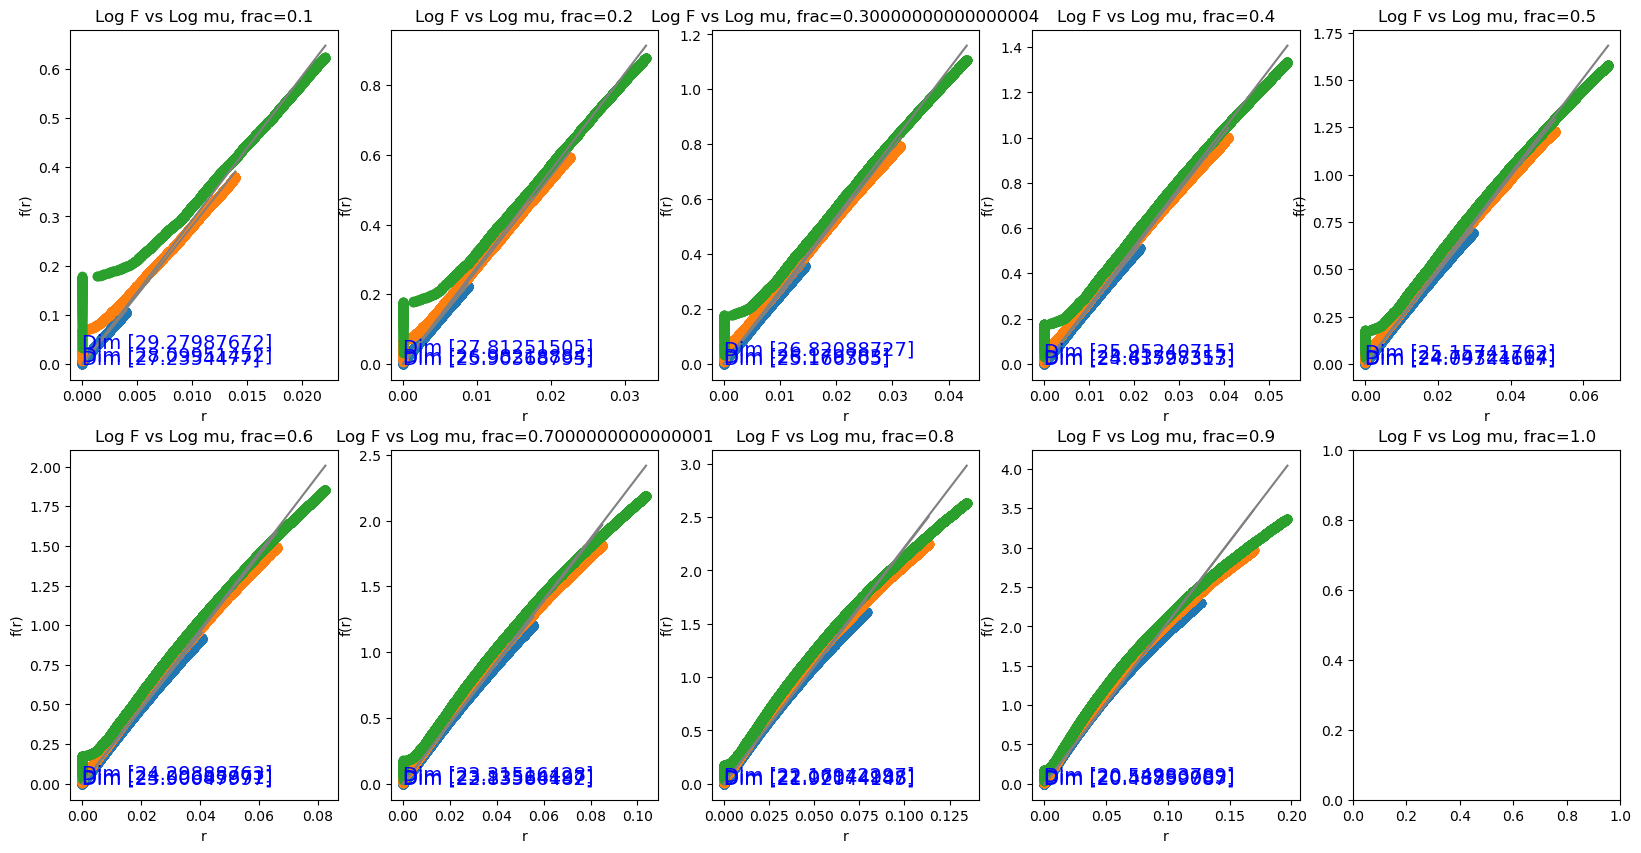

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Import your methods here
# from your_module import measure_dimension_kNN  # Adjust accordingly if needed

# Define the subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Creates a 2x5 grid of plots
axes = axes.ravel()  # Flatten the axes array for easy access

# Iterate over the fractions and generate plots
fractions = np.linspace(0.1, 1.0, 10)  # Creates 10 fractions from 0.1 to 1.0
for i, fraction in enumerate(fractions[:]):
    xs, ys, dims, regrs, npoints, _ = measure_dimension_kNN(
        activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=False, verbose=True
    )
    
                
    ax = axes[i]  # Select the appropriate subplot axis
    ax.set_title(f"Log F vs Log mu, frac={fraction}")
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        ax.scatter(x[:npoints], y[:npoints])
        ax.plot(
            x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
        )
        ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
                
    ax.set_xlabel("r")  # Set x-label
    ax.set_ylabel("f(r)")  # Set y-label
    ax.axis('on')  # Show axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the complete figure with subplots

# Save the figure
fig.savefig(Path(project_name)/'AnalysisPlot_fraction_dependency_blocks.11.hook_resid_post.pos50_withLengthFiltering.png')  # Adjust the path as needed


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [73.46526546]
From ratio 3 NN estimated dim [45.29038948]
From ratio 4 NN estimated dim [42.49287422]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [39.87796082]
From ratio 3 NN estimated dim [35.25499022]
From ratio 4 NN estimated dim [35.06066511]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [34.00672595]
From ratio 3 NN estimated dim [32.58422562]
From ratio 4 NN estimated dim [32.97084943]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [31.70535831]
From ratio 3 NN estimated dim [31.05717773]
From ratio 4 NN estimated dim [31.89718195]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [30.23029303]
From ratio 3 NN estimated dim [30.03559848]
From ratio 4 NN estimated dim [31.14134615]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [29.3176019]
From ratio 3 NN estimated dim [29.37895989]
From ratio 4 NN estimated dim [30.56368381]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [28.55808111]
From ratio 3 NN estimated dim [28.94462403]
From ratio 4 NN estimated dim [30.10859356]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [27.99823653]
From ratio 3 NN estimated dim [28.62114268]
From ratio 4 NN estimated dim [29.76328417]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [27.56555422]
From ratio 3 NN estimated dim [28.32816816]
From ratio 4 NN estimated dim [29.49972873]


/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25667781.0.0/ipykernel_87963/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [27.2354477]
From ratio 3 NN estimated dim [28.09951452]
From ratio 4 NN estimated dim [29.27987672]


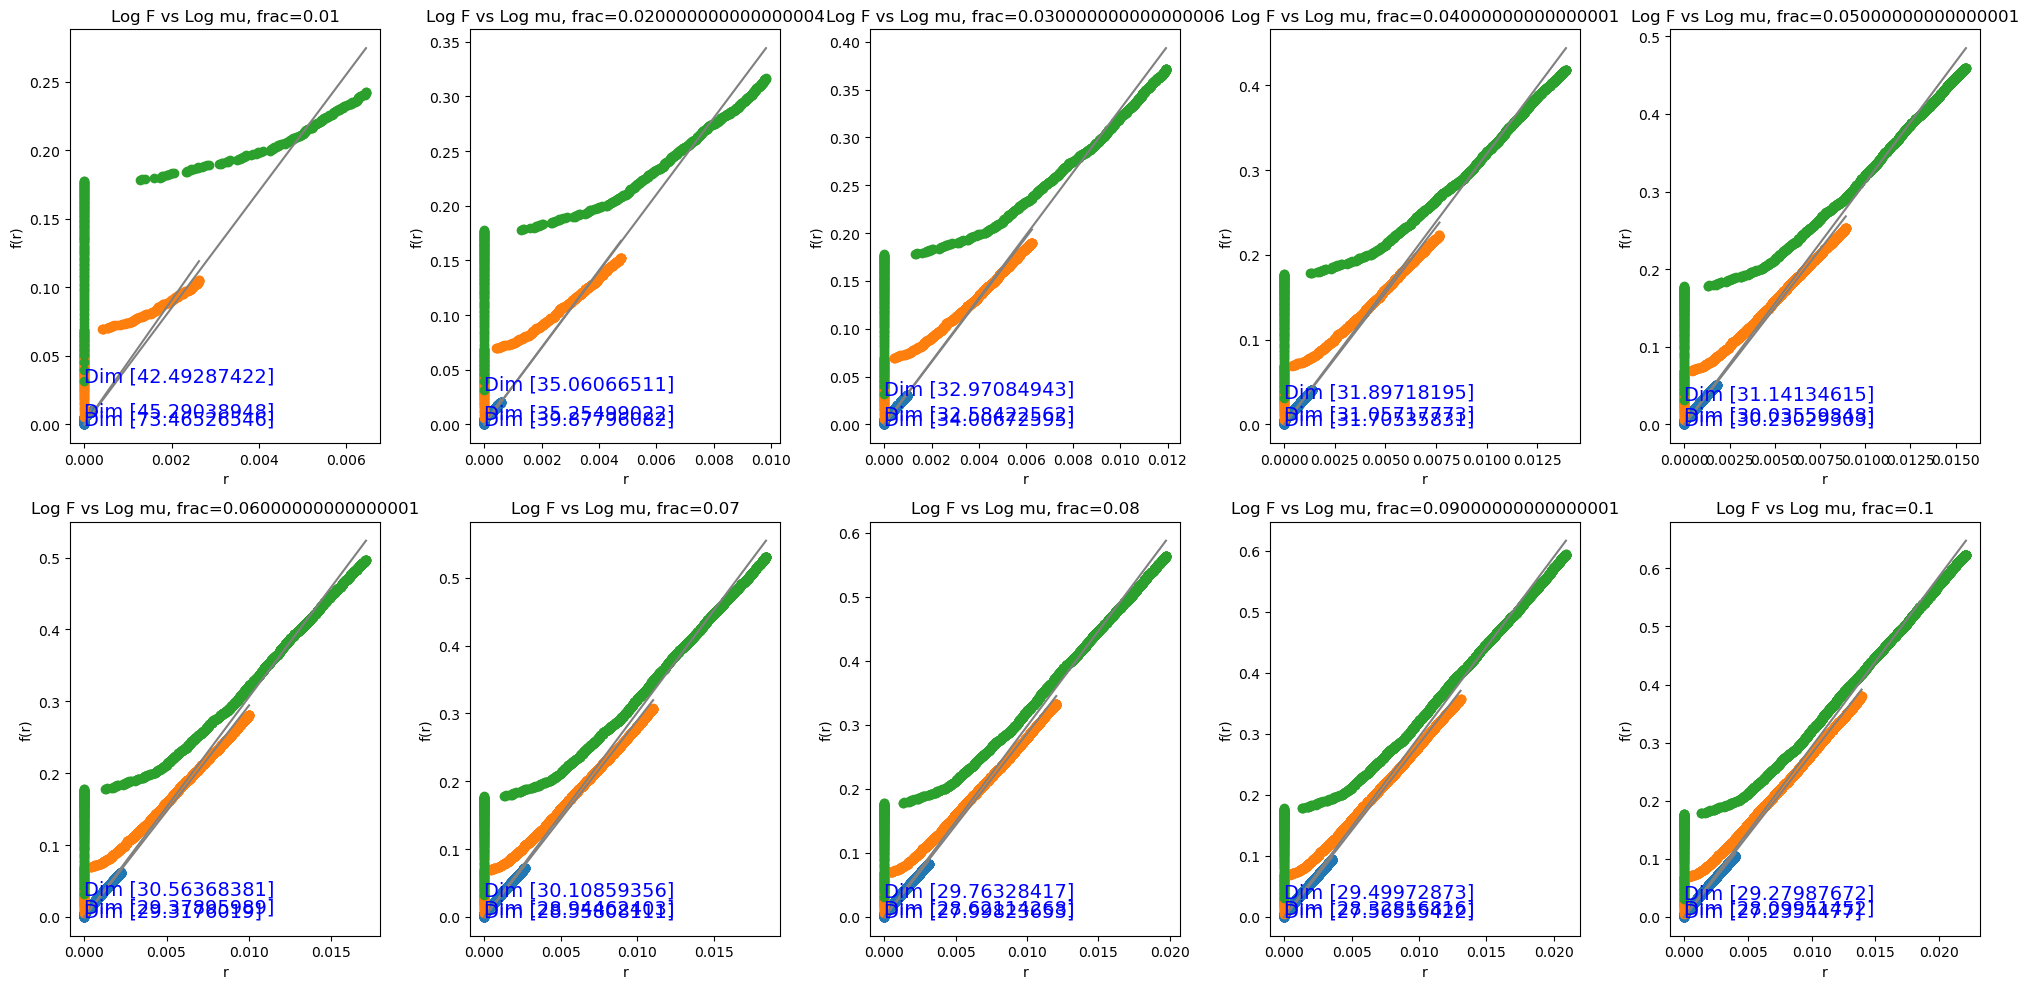

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Import your methods here
# from your_module import measure_dimension_kNN  # Adjust accordingly if needed

# Define the subplot grid
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Creates a 2x5 grid of plots
axes = axes.ravel()  # Flatten the axes array for easy access

# Iterate over the fractions and generate plots
fractions = np.linspace(0.01, 0.1, 10)  # Creates 10 fractions from 0.1 to 1.0
for i, fraction in enumerate(fractions[:]):
    xs, ys, dims, regrs, npoints, _ = measure_dimension_kNN(
        activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=False, verbose=True
    )
    
                
    ax = axes[i]  # Select the appropriate subplot axis
    ax.set_title(f"Log F vs Log mu, frac={fraction}")
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    
    
    for x, y, dim, regr in zip(xs, ys, dims, regrs):
        ax.scatter(x[:npoints], y[:npoints])
        ax.plot(
            x[:npoints], regr.predict(x[:npoints].reshape((-1, 1))), color="gray"
        )
        ax.text(x[0],y[0], f'Dim {dim}', fontsize=14, color='blue')
                
    ax.set_xlabel("r")  # Set x-label
    ax.set_ylabel("f(r)")  # Set y-label
    ax.axis('on')  # Show axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display the complete figure with subplots

# Save the figure
fig.savefig(Path(project_name)/'AnalysisPlot_fraction_dependency_blocks.11.hook_resid_post.pos50_withLengthFiltering_moreRes.png')  # Adjust the path as needed


# All activations

In [9]:
final_activations = {
    'last0': {}, 'last1': {}, 'last2': {}, 'last3': {}, 'last10': {}, 'last20': {}, 
    'pos0': {}, 'pos5': {}, 'pos10': {}, 'pos50': {}
}

target_keys_substrings = [
    "hook_attn_out",
    "hook_mlp_out",
    "hook_resid_pre",
    "hook_resid_mid",
    "hook_resid_post",
    "ln_final"
]

layer_indices = [0, 1, 2, 3, 5, 7, 9, 10, 11]
target_layers_substrings = [f"blocks.{index}" for index in layer_indices] + ["ln_final"]

# Define specific token positions

names_filter= [key for key in list(model.hook_dict.keys()) if any(substring in key for substring in target_keys_substrings)]
names_filter= [key for key in names_filter if any(substring in key for substring in target_layers_substrings)]

last_token_positions=[0,1,2,3,10,20]
token_positions = [0, 5, 10, 50]

project_name='final_activation_gpt2_set0_ctx_1024'
last_idxs= torch.load(Path(project_name)/'last_idxs.pt')



In [ ]:
file='blocks.11.hook_resid_post.pos50.pt'
activation_tensors0 = torch.load(Path(project_name)/file)
filtered_idx=(np.array(last_idxs)==1023)
activation_tensors_filtered=activation_tensors0[filtered_idx,:]

In [17]:
import itertools



In [22]:
list(itertools.product(names_filter, final_activations.keys()))[1:3]

[('blocks.0.hook_attn_out', 'last1'), ('blocks.0.hook_attn_out', 'last2')]

[array([16.35300833]), array([18.45242955]), array([19.7039132])]

SyntaxError: unexpected EOF while parsing (849521179.py, line 1)

In [ ]:
final_activations.keys()

import itertools
import pickle

# Use itertools.product to create combinations
last_token_ind=1023
fraction=0.1
keys=[]
dims_dict={}
# Print each combination
for str_i,str_j in list(itertools.product(names_filter, final_activations.keys()))[:]:
    key=f"{str_i}.{str_j}"
    file=key+".pt"
    activation_tensors0 = torch.load(Path(project_name)/file)
    filtered_data_idx=(np.array(last_idxs)==last_token_ind)
    activation_tensors_filtered=activation_tensors0[filtered_data_idx,:]
    
    xs, ys, dims, regrs, npoints, fig = measure_dimension_kNN(
        activation_tensors_filtered, n_neighbors=5, fraction=fraction, plot=True, verbose=True
    )
    
    if fig is not None:
        fig.savefig(Path(project_name) / ('plot_ID_'+file.replace(".pt", ".png")))
    
    dims_dict[key]=dims
    keys+=[key]
    
Dimension_analyzed={
    "positions" :list(final_activations.keys()),
    "layer_keys" :target_layers_substrings,
    "layer_ind":layer_indices,
    "names_filter" : names_filter,
    "keys":keys,
    "dims":dims_dict,
    "last_token_ind":last_token_ind,
    "filtered_data_idx":filtered_data_idx,
    "fraction":fraction,
    "sample_num" : len(filtered_data_idx),
    "filtered_sample_num": sum(filtered_data_idx)
}

with open(Path(project_name)/'Dimension_analyzed.pkl', 'wb') as f:
    pickle.dump(Dimension_analyzed, f)




From ratio 2 NN estimated dim [16.41107074]
From ratio 3 NN estimated dim [18.63310204]
From ratio 4 NN estimated dim [19.47454111]
From ratio 2 NN estimated dim [16.35300833]
From ratio 3 NN estimated dim [18.45242955]
From ratio 4 NN estimated dim [19.7039132]
From ratio 2 NN estimated dim [17.3457171]
From ratio 3 NN estimated dim [19.01440951]
From ratio 4 NN estimated dim [20.26013909]
From ratio 2 NN estimated dim [17.19070635]
From ratio 3 NN estimated dim [18.96357662]
From ratio 4 NN estimated dim [20.36328553]
From ratio 2 NN estimated dim [17.17547153]
From ratio 3 NN estimated dim [19.27065079]
From ratio 4 NN estimated dim [20.39707159]
From ratio 2 NN estimated dim [17.05313864]
From ratio 3 NN estimated dim [18.90224926]
From ratio 4 NN estimated dim [20.03055615]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [35.90712742]
From ratio 3 NN estimated dim [25.16353861]
From ratio 4 NN estimated dim [24.73617337]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [19.74620754]
From ratio 3 NN estimated dim [21.06179256]
From ratio 4 NN estimated dim [22.10885952]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [19.60141173]
From ratio 3 NN estimated dim [21.32439766]
From ratio 4 NN estimated dim [22.39918477]
From ratio 2 NN estimated dim [17.61703787]
From ratio 3 NN estimated dim [20.07782474]
From ratio 4 NN estimated dim [21.02428716]
From ratio 2 NN estimated dim [16.89504276]
From ratio 3 NN estimated dim [19.34725621]
From ratio 4 NN estimated dim [20.57102005]
From ratio 2 NN estimated dim [17.72808221]
From ratio 3 NN estimated dim [20.350798]
From ratio 4 NN estimated dim [21.52883393]
From ratio 2 NN estimated dim [17.5810031]
From ratio 3 NN estimated dim [20.03840092]
From ratio 4 NN estimated dim [21.588098]
From ratio 2 NN estimated dim [17.53387018]
From ratio 3 NN estimated dim [20.33168332]
From ratio 4 NN estimated dim [21.47623331]
From ratio 2 NN estimated dim [17.51114288]
From ratio 3 NN estimated dim [19.9350869]
From ratio 4 NN estimated dim [21.1639454]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [96.69579972]
From ratio 3 NN estimated dim [45.45845307]
From ratio 4 NN estimated dim [40.61119225]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [26.25780608]
From ratio 3 NN estimated dim [28.25675253]
From ratio 4 NN estimated dim [28.8523262]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [22.44528321]
From ratio 3 NN estimated dim [25.50180721]
From ratio 4 NN estimated dim [26.99496403]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 7))


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ratio 4 NN estimated dim [0.]
From ratio 2 NN estimated dim [16.58628615]
From ratio 3 NN estimated dim [18.56776356]
From ratio 4 NN estimated dim [19.59242934]
From ratio 2 NN estimated dim [16.47825532]
From ratio 3 NN estimated dim [18.49653909]
From ratio 4 NN estimated dim [19.76389775]
From ratio 2 NN estimated dim [17.08444301]
From ratio 3 NN estimated dim [19.13101951]
From ratio 4 NN estimated dim [20.3944504]
From ratio 2 NN estimated dim [17.15256554]
From ratio 3 NN estimated dim [19.04029327]
From ratio 4 NN estimated dim [20.41506072]
From ratio 2 NN estimated dim [17.15935233]
From ratio 3 NN estimated dim [19.21387174]
From ratio 4 NN estimated dim [20.53776097]
From ratio 2 NN estimated dim [17.17556768]
From ratio 3 NN estimated dim [18.80292791]
From ratio 4 NN estimated dim [19.96224704]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [34.42320867]
From ratio 3 NN estimated dim [25.63900378]
From ratio 4 NN estimated dim [25.08883788]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [19.37486762]
From ratio 3 NN estimated dim [20.81115759]
From ratio 4 NN estimated dim [21.98005918]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [18.91039501]
From ratio 3 NN estimated dim [20.6058771]
From ratio 4 NN estimated dim [21.79551561]
From ratio 2 NN estimated dim [15.49687712]
From ratio 3 NN estimated dim [17.21786516]
From ratio 4 NN estimated dim [18.12677132]
From ratio 2 NN estimated dim [15.59943397]
From ratio 3 NN estimated dim [17.69739885]
From ratio 4 NN estimated dim [18.83661035]
From ratio 2 NN estimated dim [16.19243687]
From ratio 3 NN estimated dim [18.39333705]
From ratio 4 NN estimated dim [19.60138707]
From ratio 2 NN estimated dim [16.32150754]
From ratio 3 NN estimated dim [18.13898152]
From ratio 4 NN estimated dim [19.13709265]
From ratio 2 NN estimated dim [16.23904499]
From ratio 3 NN estimated dim [18.44299584]
From ratio 4 NN estimated dim [19.52779693]
From ratio 2 NN estimated dim [16.33391249]
From ratio 3 NN estimated dim [18.36699303]
From ratio 4 NN estimated dim [19.30847615]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [43.14966152]
From ratio 3 NN estimated dim [30.62246831]
From ratio 4 NN estimated dim [28.62314859]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [22.2663722]
From ratio 3 NN estimated dim [23.15860813]
From ratio 4 NN estimated dim [24.1229004]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [18.24953013]
From ratio 3 NN estimated dim [20.52155167]
From ratio 4 NN estimated dim [21.62371213]
From ratio 2 NN estimated dim [30.75247506]
From ratio 3 NN estimated dim [32.42347437]
From ratio 4 NN estimated dim [32.63772197]
From ratio 2 NN estimated dim [29.5134876]
From ratio 3 NN estimated dim [31.19509224]
From ratio 4 NN estimated dim [31.99197248]
From ratio 2 NN estimated dim [30.08176952]
From ratio 3 NN estimated dim [30.96066985]
From ratio 4 NN estimated dim [31.90637562]
From ratio 2 NN estimated dim [30.30034449]
From ratio 3 NN estimated dim [31.03487864]
From ratio 4 NN estimated dim [32.13127258]
From ratio 2 NN estimated dim [30.61527827]
From ratio 3 NN estimated dim [31.20685478]
From ratio 4 NN estimated dim [32.22862304]
From ratio 2 NN estimated dim [30.79126878]
From ratio 3 NN estimated dim [31.59552095]
From ratio 4 NN estimated dim [32.44468309]
From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From ra

/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [420.75719192]
From ratio 3 NN estimated dim [57.04612861]
From ratio 4 NN estimated dim [44.25746421]
From ratio 2 NN estimated dim [39.61473339]
From ratio 3 NN estimated dim [36.35323748]
From ratio 4 NN estimated dim [35.80136684]
From ratio 2 NN estimated dim [35.05697259]
From ratio 3 NN estimated dim [34.98131118]
From ratio 4 NN estimated dim [35.37503334]
From ratio 2 NN estimated dim [28.59392612]
From ratio 3 NN estimated dim [37.42444027]
From ratio 4 NN estimated dim [42.24362386]
From ratio 2 NN estimated dim [42.47777712]
From ratio 3 NN estimated dim [63.10912953]
From ratio 4 NN estimated dim [78.61322459]
From ratio 2 NN estimated dim [42.53249413]
From ratio 3 NN estimated dim [64.79321474]
From ratio 4 NN estimated dim [81.44401235]
From ratio 2 NN estimated dim [43.70899003]
From ratio 3 NN estimated dim [65.61651333]
From ratio 4 NN estimated dim [82.33836024]
From ratio 2 NN estimated dim [42.70184066]
From ratio 3 NN estimated dim [

/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [754.45388463]
From ratio 3 NN estimated dim [153.58553814]
From ratio 4 NN estimated dim [140.71045699]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [52.13802876]
From ratio 3 NN estimated dim [71.54474328]
From ratio 4 NN estimated dim [86.37349515]
From ratio 2 NN estimated dim [46.82382281]
From ratio 3 NN estimated dim [70.09017258]
From ratio 4 NN estimated dim [86.18678297]
From ratio 2 NN estimated dim [15.49687712]
From ratio 3 NN estimated dim [17.21786516]
From ratio 4 NN estimated dim [18.12677132]
From ratio 2 NN estimated dim [15.59943397]
From ratio 3 NN estimated dim [17.69739885]
From ratio 4 NN estimated dim [18.83661035]
From ratio 2 NN estimated dim [16.19243687]
From ratio 3 NN estimated dim [18.39333705]
From ratio 4 NN estimated dim [19.60138707]
From ratio 2 NN estimated dim [16.32150754]
From ratio 3 NN estimated dim [18.13898152]
From ratio 4 NN estimated dim [19.13709265]
From ratio 2 NN estimated dim [16.23904499]
From ratio 3 NN estimated dim [18.44299584]
From ratio 4 NN estimated dim [19.52779693]
From ratio 2 NN estimated dim [16.33391249]
From ratio 3 NN estimated dim [1

/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [43.14966152]
From ratio 3 NN estimated dim [30.62246831]
From ratio 4 NN estimated dim [28.62314859]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [22.2663722]
From ratio 3 NN estimated dim [23.15860813]
From ratio 4 NN estimated dim [24.1229004]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [18.24953013]
From ratio 3 NN estimated dim [20.52155167]
From ratio 4 NN estimated dim [21.62371213]
From ratio 2 NN estimated dim [18.27175431]
From ratio 3 NN estimated dim [19.97750328]
From ratio 4 NN estimated dim [21.04090707]
From ratio 2 NN estimated dim [16.03717186]
From ratio 3 NN estimated dim [18.5360801]
From ratio 4 NN estimated dim [19.77555834]
From ratio 2 NN estimated dim [16.78055005]
From ratio 3 NN estimated dim [18.7108913]
From ratio 4 NN estimated dim [19.93308847]
From ratio 2 NN estimated dim [16.75640658]
From ratio 3 NN estimated dim [19.11275825]
From ratio 4 NN estimated dim [20.2935525]
From ratio 2 NN estimated dim [16.46305747]
From ratio 3 NN estimated dim [18.49052004]
From ratio 4 NN estimated dim [19.9561628]
From ratio 2 NN estimated dim [16.88292066]
From ratio 3 NN estimated dim [18.85060228]
From ratio 4 NN estimated dim [19.90107492]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [58.03662974]
From ratio 3 NN estimated dim [32.54728957]
From ratio 4 NN estimated dim [28.69701408]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [22.10548976]
From ratio 3 NN estimated dim [23.21064427]
From ratio 4 NN estimated dim [23.81245493]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [18.67713492]
From ratio 3 NN estimated dim [20.48947187]
From ratio 4 NN estimated dim [21.68078827]
From ratio 2 NN estimated dim [14.76529251]
From ratio 3 NN estimated dim [16.17626358]
From ratio 4 NN estimated dim [16.9385386]
From ratio 2 NN estimated dim [13.91589341]
From ratio 3 NN estimated dim [15.49947231]
From ratio 4 NN estimated dim [16.36389372]
From ratio 2 NN estimated dim [13.88304048]
From ratio 3 NN estimated dim [15.83262292]
From ratio 4 NN estimated dim [16.71091807]
From ratio 2 NN estimated dim [14.46425352]
From ratio 3 NN estimated dim [15.7000118]
From ratio 4 NN estimated dim [16.68755975]
From ratio 2 NN estimated dim [13.61631175]
From ratio 3 NN estimated dim [15.12426537]
From ratio 4 NN estimated dim [16.30082659]
From ratio 2 NN estimated dim [14.52744133]
From ratio 3 NN estimated dim [15.68519175]
From ratio 4 NN estimated dim [16.4613315]
From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From rati

/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [64.99553713]
From ratio 3 NN estimated dim [31.18257426]
From ratio 4 NN estimated dim [26.9987296]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [17.90177247]
From ratio 3 NN estimated dim [18.4901712]
From ratio 4 NN estimated dim [18.95138268]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [15.76143457]
From ratio 3 NN estimated dim [17.1923992]
From ratio 4 NN estimated dim [17.99320598]
From ratio 2 NN estimated dim [27.93752831]
From ratio 3 NN estimated dim [28.88845745]
From ratio 4 NN estimated dim [29.69268605]
From ratio 2 NN estimated dim [27.74444652]
From ratio 3 NN estimated dim [30.05846579]
From ratio 4 NN estimated dim [31.08568077]
From ratio 2 NN estimated dim [28.62651654]
From ratio 3 NN estimated dim [30.45558256]
From ratio 4 NN estimated dim [31.74458742]
From ratio 2 NN estimated dim [28.42926385]
From ratio 3 NN estimated dim [30.27638367]
From ratio 4 NN estimated dim [31.73544782]
From ratio 2 NN estimated dim [27.73926711]
From ratio 3 NN estimated dim [30.25623799]
From ratio 4 NN estimated dim [31.36053995]
From ratio 2 NN estimated dim [28.58442757]
From ratio 3 NN estimated dim [29.2645439]
From ratio 4 NN estimated dim [30.68267419]
From ratio 2 NN estimated dim [0.]
From ratio 3 NN estimated dim [0.]
From rat

/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [582.06405394]
From ratio 3 NN estimated dim [54.78865929]
From ratio 4 NN estimated dim [41.45365437]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [35.45569866]
From ratio 3 NN estimated dim [32.36679143]
From ratio 4 NN estimated dim [32.62466453]


/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: invalid value encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]
/state/partition1/slurm_tmp/25671458.0.0/ipykernel_131526/1136533990.py:11: RuntimeWarning: divide by zero encountered in divide
  [distances[:, i] / distances[:, 1] for i in range(2, n_neighbors)]


From ratio 2 NN estimated dim [30.20749151]
From ratio 3 NN estimated dim [31.59266943]
From ratio 4 NN estimated dim [32.80926265]
From ratio 2 NN estimated dim [35.32456373]
From ratio 3 NN estimated dim [46.380516]
From ratio 4 NN estimated dim [54.51757253]
From ratio 2 NN estimated dim [49.10894025]
From ratio 3 NN estimated dim [74.88040961]
From ratio 4 NN estimated dim [89.25112184]


In [46]:
# Load the data from the .pkl file
with open(Path(project_name)/'Dimension_analyzed.pkl', 'rb') as file:
    Dimension_analyzed= pickle.load(file)


In [47]:
Dimension_analyzed

{'positions': ['last0',
  'last1',
  'last2',
  'last3',
  'last10',
  'last20',
  'pos0',
  'pos5',
  'pos10',
  'pos50'],
 'layer_keys': ['blocks.0',
  'blocks.1',
  'blocks.2',
  'blocks.3',
  'blocks.5',
  'blocks.7',
  'blocks.9',
  'blocks.10',
  'blocks.11',
  'ln_final'],
 'layer_ind': [0, 1, 2, 3, 5, 7, 9, 10, 11],
 'names_filter': ['blocks.0.hook_attn_out',
  'blocks.0.hook_mlp_out',
  'blocks.0.hook_resid_pre',
  'blocks.0.hook_resid_mid',
  'blocks.0.hook_resid_post',
  'blocks.1.hook_attn_out',
  'blocks.1.hook_mlp_out',
  'blocks.1.hook_resid_pre',
  'blocks.1.hook_resid_mid',
  'blocks.1.hook_resid_post',
  'blocks.2.hook_attn_out',
  'blocks.2.hook_mlp_out',
  'blocks.2.hook_resid_pre',
  'blocks.2.hook_resid_mid',
  'blocks.2.hook_resid_post',
  'blocks.3.hook_attn_out',
  'blocks.3.hook_mlp_out',
  'blocks.3.hook_resid_pre',
  'blocks.3.hook_resid_mid',
  'blocks.3.hook_resid_post',
  'blocks.5.hook_attn_out',
  'blocks.5.hook_mlp_out',
  'blocks.5.hook_resid_pre',
  